In [121]:
# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #ÂùáÊñπËØØÂ∑Æ
from sklearn.metrics import mean_absolute_error #Âπ≥ÊñπÁªùÂØπËØØÂ∑Æ
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp

In [122]:
# feature importance ÁâπÂæÅÈáçË¶ÅÊÄß
def feture_importance(features, indices, importances):

    print("%%%%%% feature importances %%%%%%")

    '''
    for i in indices:
        print(features[i], importances[i])
    '''

    plt.barh(range(len(indices)), importances[indices], color='b', align='center', alpha=0.5)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('feature Importance')
    plt.show()


# ËØÑ‰ª∑ÊåáÊ†á
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

    ############# ËÆæÁΩÆÂõæ‰æãÂπ∂‰∏îËÆæÁΩÆÂõæ‰æãÁöÑÂ≠ó‰ΩìÂèäÂ§ßÂ∞è #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# ËÆæÁΩÆÂùêÊ†áÂàªÂ∫¶ÂÄºÁöÑÂ§ßÂ∞è‰ª•ÂèäÂàªÂ∫¶ÂÄºÁöÑÂ≠ó‰Ωì #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # xÔºåyËΩ¥ËÆæÁΩÆÊòæÁ§∫ÂàªÂ∫¶‰∏ÄËá¥
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# Áñ´ÊÉÖÂª∫Ê®°
def covid_all_predict(df, index, threshold):
    
    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
    'confirmed','confirmLog']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    clf = []
    for i in range(len(index)):
        clf.append(RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=5))
    

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog']
        train_y = train_df['confirmed']

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

        test_y = test_df['confirmed']
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

        clf[i].fit(train_x, train_y_log)

        predict_ytrain_log = clf[i].predict(train_x)
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = clf[i].predict(test_x)
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)

        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = train_y.to_list()
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])

        evaluation(train_y, predict_ytrain)

        print("#########################################")
        print("test fold " + str(i+1))
        print("È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = test_y.to_list()
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_y, predict_ytest)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    # feature importance
    train_y = df['confirmLog']
    train_x = df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

    clf = RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=5)
    clf.fit(train_x, train_y)

    features = list(train_x)
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    feture_importance(features, indices, importances)

    return case, df_predict

In [123]:
# ÊâÄÊúâÂüéÂ∏ÇÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°

train fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 580   pre:451.0
Â§©Ê¥•Â∏Ç   real: 174   pre:79.0
ÂìàÂ∞îÊª®Â∏Ç   real: 198   pre:123.0
‰∏äÊµ∑Â∏Ç   real: 516   pre:382.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:74.0
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:178.0
ËöåÂü†Â∏Ç   real: 160   pre:27.0
ÂçóÊòåÂ∏Ç   real: 230   pre:166.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:15.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:54.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:49.0
ÈÉëÂ∑ûÂ∏Ç   real: 157   pre:279.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:881.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:1152.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:1023.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:1126.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1055.0
‰ªôÊ°ÉÂ∏Ç   real: 575   pre:793.0
ÊΩúÊ±üÂ∏Ç   real: 198   pre:328.0
Áè†Êµ∑Â∏Ç   real: 103   pre:52.0
ÈáçÂ∫ÜÂ∏Ç   real: 579   pre:401.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 78   pre:5.0
R-squared 0.9045269639763969
R 0.9510662248110785
mae 22.770833333333332
rmse 60.174087723316035


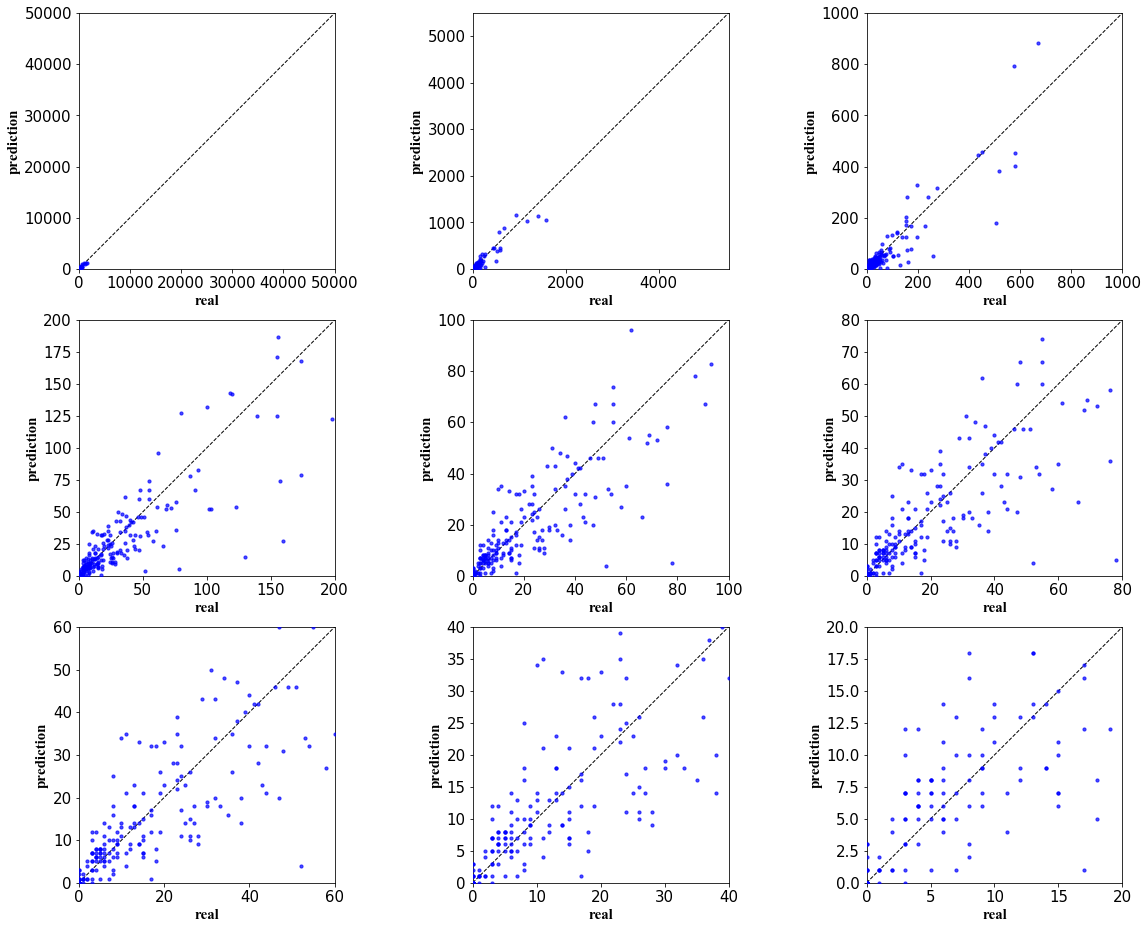

#########################################
test fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Êù≠Â∑ûÂ∏Ç   real: 181   pre:99.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:45.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:32.0
ÂÆúÊò•Â∏Ç   real: 106   pre:48.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:845.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:861.0
ËçÜÈó®Â∏Ç   real: 928   pre:861.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:1055.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:1055.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:1126.0
ÈöèÂ∑ûÂ∏Ç   real: 1307   pre:588.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:1152.0
Â§©Èó®Â∏Ç   real: 496   pre:370.0
R-squared 0.13488818230330354
R 0.3672712652839908
mae 470.92561983471074
rmse 4479.337076468805


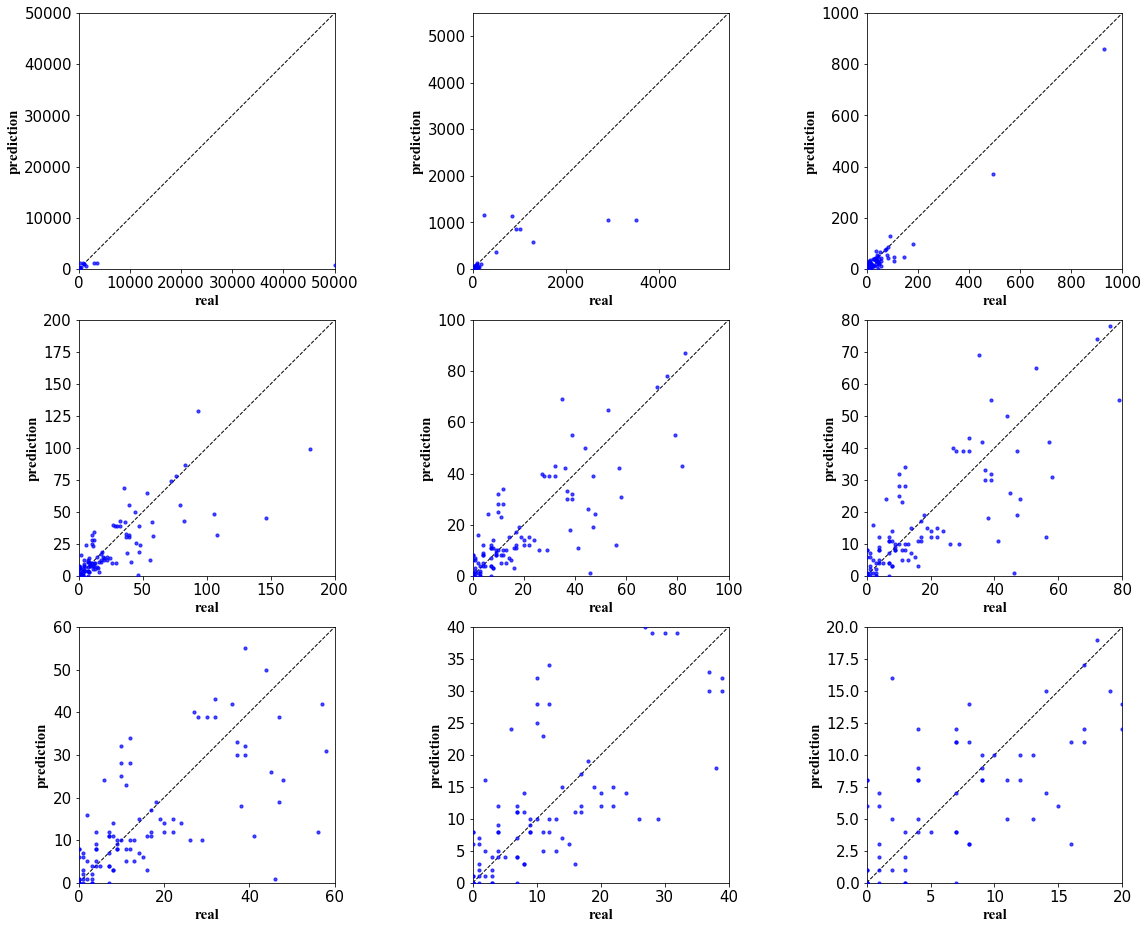

train fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 580   pre:502.0
Êù≠Â∑ûÂ∏Ç   real: 181   pre:121.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:81.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:74.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:53.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:12.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:13413.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:838.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:787.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:1625.0
ËçÜÈó®Â∏Ç   real: 928   pre:753.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:2209.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1492.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:2209.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:1093.0
ÈöèÂ∑ûÂ∏Ç   real: 1307   pre:784.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:565.0
Â§©Èó®Â∏Ç   real: 496   pre:583.0
ÂπøÂ∑ûÂ∏Ç   real: 435   pre:195.0
Ê∑±Âú≥Â∏Ç   real: 450   pre:537.0
ÈáçÂ∫ÜÂ∏Ç   real: 579   pre:505.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 78   pre:14.0
R-squared 0.9566081388825618
R 0.9780634636272647
mae 179.1908713692946
rmse 2359.7431193271054


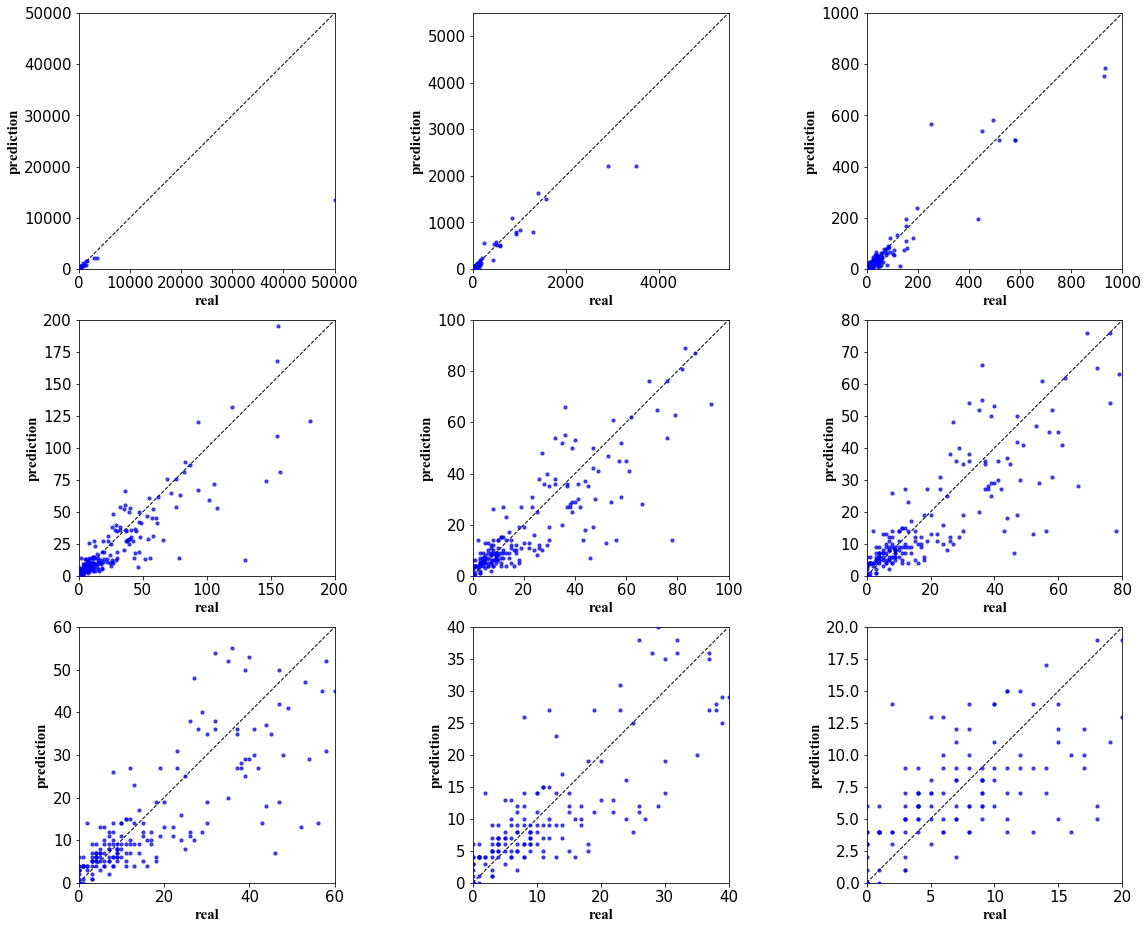

#########################################
test fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Â§©Ê¥•Â∏Ç   real: 174   pre:52.0
ÂìàÂ∞îÊª®Â∏Ç   real: 198   pre:42.0
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:73.0
ËöåÂü†Â∏Ç   real: 160   pre:11.0
ÂçóÊòåÂ∏Ç   real: 230   pre:145.0
‰πùÊ±üÂ∏Ç   real: 118   pre:173.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:45.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:34.0
ÈÉëÂ∑ûÂ∏Ç   real: 157   pre:437.0
‰ø°Èò≥Â∏Ç   real: 274   pre:411.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:784.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:787.0
‰ªôÊ°ÉÂ∏Ç   real: 575   pre:784.0
ÈïøÊ≤ôÂ∏Ç   real: 242   pre:483.0
Ê†™Ê¥≤Â∏Ç   real: 80   pre:132.0
Â≤≥Èò≥Â∏Ç   real: 156   pre:207.0
Áè†Êµ∑Â∏Ç   real: 103   pre:46.0
R-squared 0.7294539127851214
R 0.8540807413735082
mae 32.90833333333333
rmse 76.92859243046979


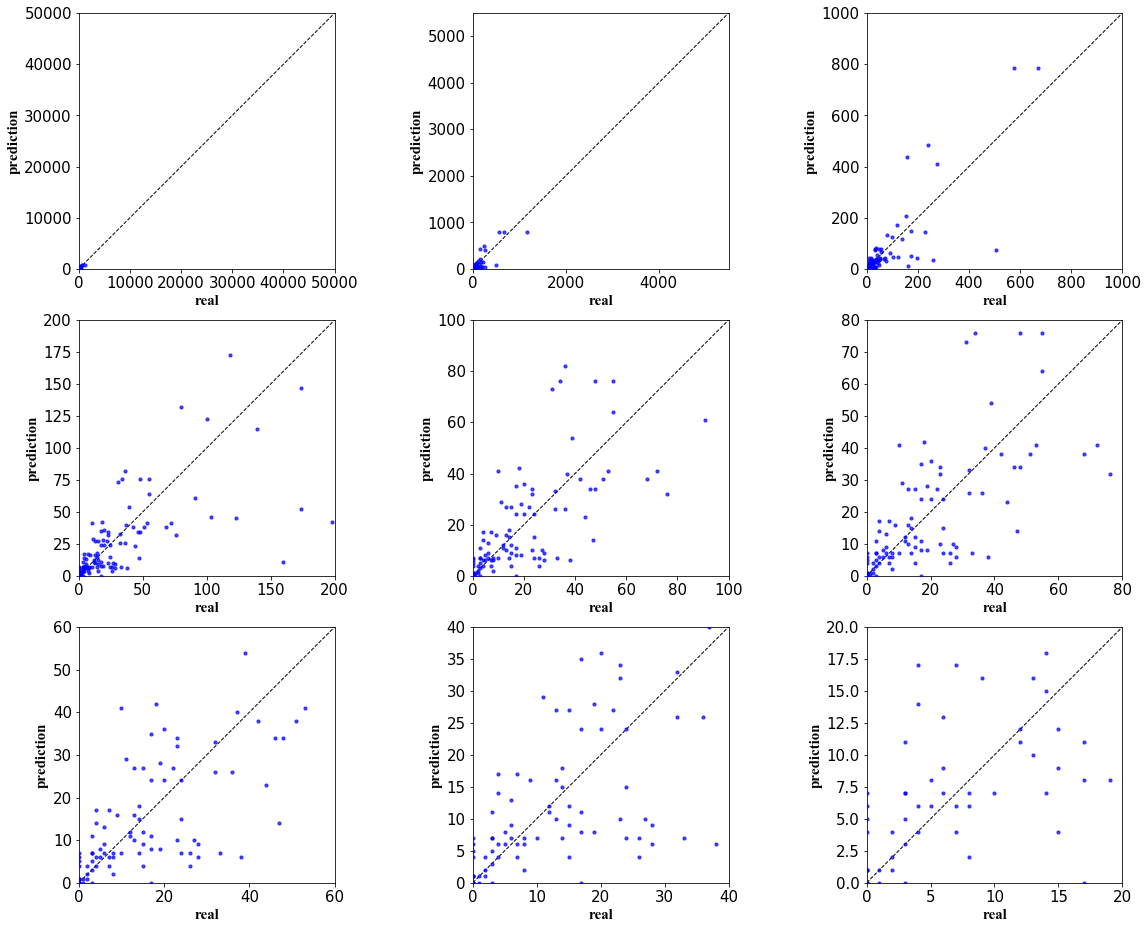

train fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Â§©Ê¥•Â∏Ç   real: 174   pre:110.0
ÂìàÂ∞îÊª®Â∏Ç   real: 198   pre:112.0
Ê∏©Â∑ûÂ∏Ç   real: 504   pre:221.0
Âè∞Â∑ûÂ∏Ç   real: 146   pre:61.0
ËöåÂü†Â∏Ç   real: 160   pre:35.0
‰∫≥Â∑ûÂ∏Ç   real: 108   pre:36.0
‰∏äÈ•∂Â∏Ç   real: 123   pre:53.0
ÊµéÂÆÅÂ∏Ç   real: 260   pre:61.0
‰ø°Èò≥Â∏Ç   real: 274   pre:164.0
Ê≠¶Ê±âÂ∏Ç   real: 50006   pre:11237.0
ÈªÑÁü≥Â∏Ç   real: 1015   pre:1273.0
ÂçÅÂ†∞Â∏Ç   real: 672   pre:821.0
Ë•ÑÈò≥Â∏Ç   real: 1175   pre:943.0
ËçÜÈó®Â∏Ç   real: 928   pre:848.0
Â≠ùÊÑüÂ∏Ç   real: 3518   pre:3239.0
ÈªÑÂÜàÂ∏Ç   real: 2907   pre:1879.0
Âí∏ÂÆÅÂ∏Ç   real: 836   pre:1233.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 252   pre:650.0
‰ªôÊ°ÉÂ∏Ç   real: 575   pre:1031.0
Â§©Èó®Â∏Ç   real: 496   pre:781.0
‰∏úËéûÂ∏Ç   real: 100   pre:204.0
R-squared 0.9123648548689667
R 0.9551779179131847
mae 188.39834024896265
rmse 2499.0868855265494


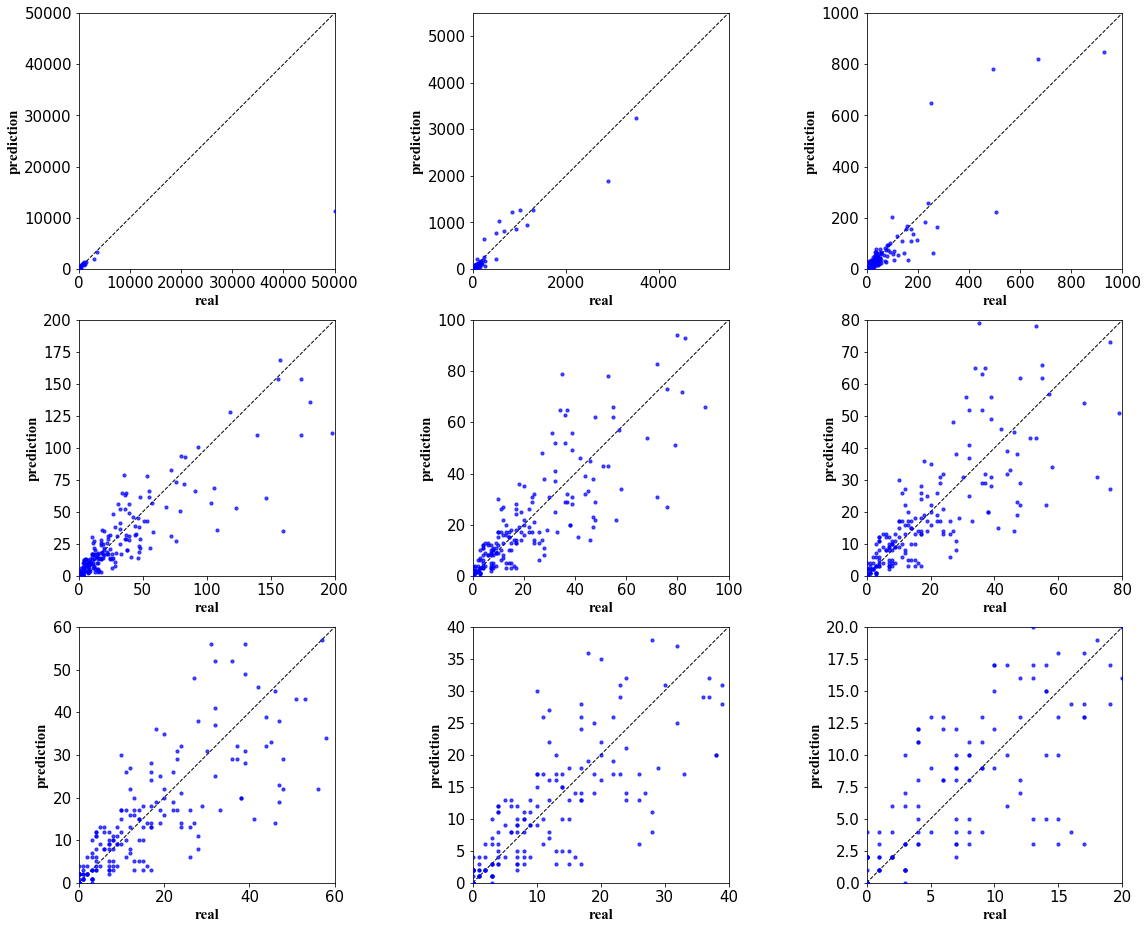

#########################################
test fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 580   pre:175.0
‰∏äÊµ∑Â∏Ç   real: 516   pre:135.0
ÂÆÅÊ≥¢Â∏Ç   real: 157   pre:65.0
ÈòúÈò≥Â∏Ç   real: 155   pre:101.0
Êñ∞‰ΩôÂ∏Ç   real: 130   pre:12.0
ÂÆúÊòåÂ∏Ç   real: 931   pre:752.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1394   pre:3694.0
ËçÜÂ∑ûÂ∏Ç   real: 1580   pre:1522.0
ÊΩúÊ±üÂ∏Ç   real: 198   pre:466.0
ÈÇµÈò≥Â∏Ç   real: 102   pre:31.0
ÂπøÂ∑ûÂ∏Ç   real: 435   pre:195.0
Ê∑±Âú≥Â∏Ç   real: 450   pre:195.0
‰ΩõÂ±±Â∏Ç   real: 93   pre:168.0
ÈáçÂ∫ÜÂ∏Ç   real: 579   pre:211.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 78   pre:6.0
Ë•øÂÆâÂ∏Ç   real: 120   pre:212.0
R-squared 0.6716218856183197
R 0.819525402668105
mae 50.141666666666666
rmse 224.2553418167187


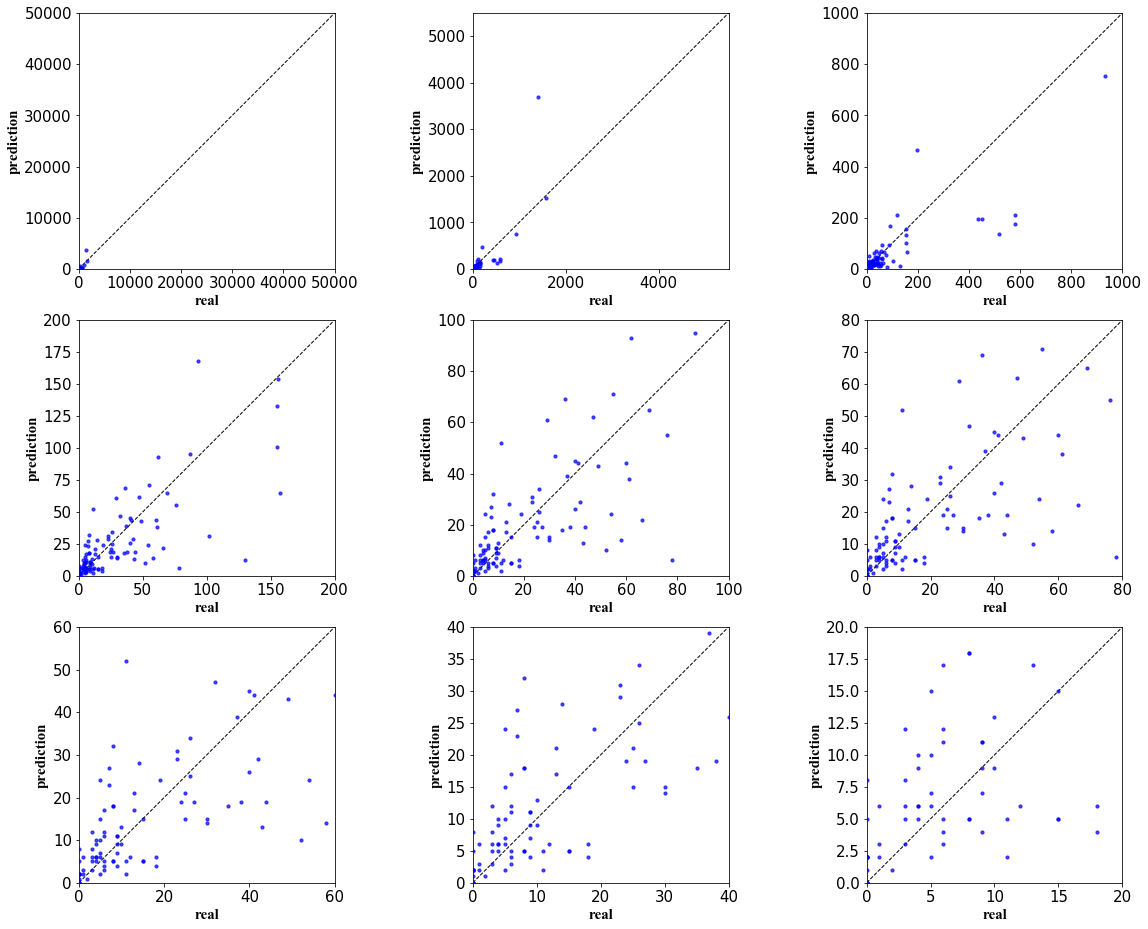

************* cv evaluation ***************
R-squared 0.05334894284415661
R 0.2309739007856875
mae 185.45152354570638
rmse 2596.900322561218


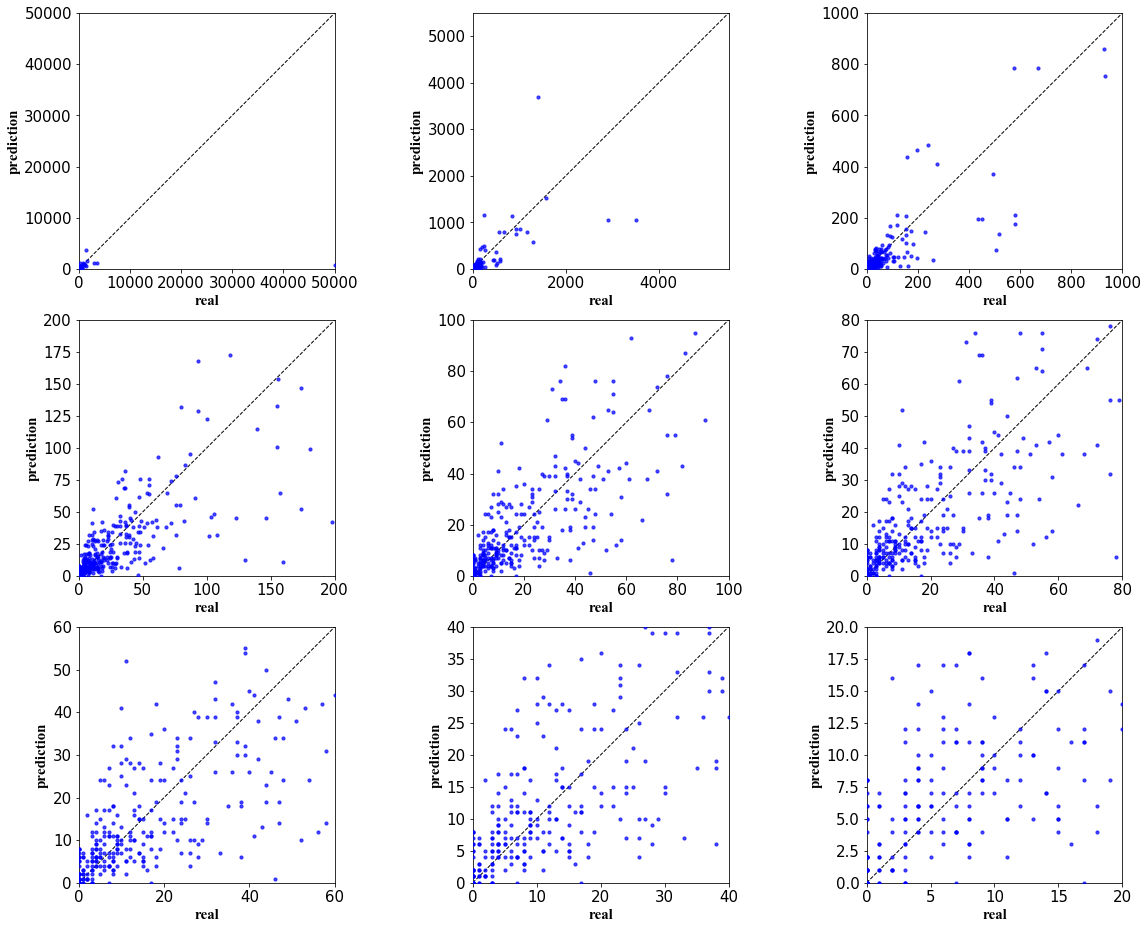

%%%%%% feature importances %%%%%%


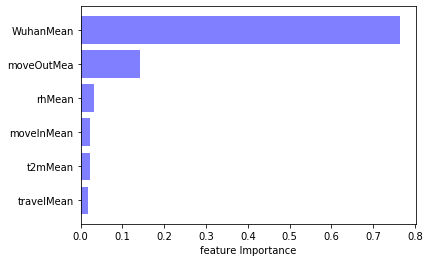

In [124]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id Áñ´ÊÉÖÁÅæÂå∫idÔºåÊöÇÂÆöÊ≠¶Ê±â
epidemicIds = [420100]

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 50)

In [125]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [126]:
# È¢ÑÊµãËøá‰ΩéÁöÑÂüéÂ∏Ç

# ÊπñÂåóÂüéÂ∏ÇÂæàÂ§öÈ¢ÑÊµãËøá‰ΩéÔºåÊØîÂ¶ÇÈöèÂ∑ûÔºåËçÜÂ∑ûÔºåË•ÑÈò≥ÔºåÈªÑÁü≥ÔºåÂÆúÊòåÔºåËøô‰∫õÂüéÂ∏ÇÁöÑWuhanMeanÂíåconfirmedÂπ∂‰∏çÂÆåÂÖ®ÂëàÊ≠£ÂêëÂÖ≥Á≥ªÔºåÊ∞îÂÄôÁâπÂæÅÂíåÂÖ∂‰ªñ‰∫§ÈÄöÂü∫Êú¨Áõ∏Ëøë

# Ê∏©Â∑ûÈ¢ÑÊµãÂæà‰ΩéÔºåËøô‰∏™ÂüéÂ∏ÇÊµÅÂä®‰∫∫Âè£ÂæàÂ§öÔºåÊòØÊµôÊ±üÁñ´ÊÉÖÊúÄ‰∏•ÈáçÁöÑÂüéÂ∏ÇÔºå‰ΩÜÊòØÁôæÂ∫¶ËøÅÂæôÂπ≥Âè∞‰∏äÁõ∏ÂÖ≥ÁöÑÊåáÊï∞Âæà‰ΩéÔºåÂ∞§ÂÖ∂ÊòØWuhanMeanÔºåÂ∫îËØ•ÊòØÊï∞ÊçÆÂ≠òÂú®‰∫õËØØÂ∑ÆÔºåËøÅÂÖ•ËøÅÂá∫Ê∏©Â∑ûÁöÑ‰∫∫Â§ßÈÉ®ÂàÜÊòØÂä°Â∑•‰∫∫ÂëòÔºåÂèØËÉΩ‰∏çÁî®ÁôæÂ∫¶ÔºüÔºüÔºü

# ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑ûÔºåÂèåÈ∏≠Â±±Â∏ÇÔºåÊñ∞‰ΩôÂ∏ÇÔºåËöåÂü†Â∏ÇÔºåÊµéÂÆÅÂ∏ÇÔºåÂìàÂ∞îÊª®Â∏ÇÔºåËøô‰∫õÂüéÂ∏ÇÁ°ÆËØä‰∫∫Êï∞Âú®50~300Ôºå‰ΩÜÊòØÈ¢ÑÊµãÂÄºÂùáÂú®30‰ª•‰∏ãÔºåÂÖ∂ÂÖ±ÂêåÁâπÁÇπÊòØWuhanMeanÂæà‰ΩéÔºåÂá†‰πéÊé•Ëøë‰∫é0

# ÂÖ∂‰ªñÈ¢ÑÊµãËøá‰ΩéÁöÑÂüéÂ∏ÇÂÖ±ÂêåÁöÑÁâπÂæÅÈÉΩÊòØWuhanMeanÂàÜÂ∏ÉËæÉ‰∏∫Êé•Ëøë


# ËôΩÁÑ∂WuhanMeanÁâπÂæÅËÉΩÂ§üË°®ÂæÅÊê∫Â∏¶ÁóÖÊØí‰∫∫Áæ§ÁöÑËøÅÂæôÂØºËá¥Áñ´ÊÉÖÊâ©Êï£Ôºå‰ΩÜÊòØÂæàÂ§öÂüéÂ∏ÇÂπ∂‰∏çÊòØ‰∏éÊ≠¶Ê±âÊúâÁõ¥Êé•ÁöÑËÅîÁ≥ªÔºå
# ÊàñËÆ∏ÈúÄË¶ÅÂä†ÂÖ•ÂüéÂ∏Ç‰∏éÁúÅ‰ºöÂüéÂ∏ÇÁöÑËøÅÂæôÂÖ≥Á≥ªÔºåÁÆóÊòØ‰∫∫Âè£ÁöÑ‰∫åÊ¨°ËøÅÂæôÔºåËÄåÊôÆÈÄöÊú∫Âô®Â≠¶‰π†Á≠õÈÄâÂÜçÂ§öÁöÑÁâπÂæÅÔºåÂØπ‰∫éËøôÁßçÁ©∫Èó¥ÂõæÁöÑË°®ÂæÅÈÉΩË¶ÅÂº±ÂæàÂ§öÔºåÊàñËÆ∏ÈúÄË¶ÅÂõæÂç∑ÁßØËØï‰∏Ä‰∏ãÊïàÊûú

In [127]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
167  420100      Ê≠¶Ê±âÂ∏Ç      50006    845.0  71.607512  282.498292    1.441894   
174  420900      Â≠ùÊÑüÂ∏Ç       3518   1055.0  71.152424  281.712290    0.581259   
176  421100      ÈªÑÂÜàÂ∏Ç       2907   1055.0  73.669439  281.858747    0.785669   
178  421300      ÈöèÂ∑ûÂ∏Ç       1307    588.0  70.903198  281.069625    0.238099   
88   330300      Ê∏©Â∑ûÂ∏Ç        504     73.0  78.798802  284.332806    1.139140   
0    110000      Âåó‰∫¨Â∏Ç        580    175.0  46.602664  272.940185    4.460553   
171  420600      Ë•ÑÈò≥Â∏Ç       1175    787.0  71.201756  280.692857    0.499872   
72   310000      ‰∏äÊµ∑Â∏Ç        516    135.0  73.452783  282.566128    4.328343   
251  500000      ÈáçÂ∫ÜÂ∏Ç        579    211.0  77.692175  282.481705    3.243957   
200  440300      Ê∑±Âú≥Â∏Ç        450    195.0  75.376723  291.932983    5.067225   
198  440100      ÂπøÂ∑ûÂ∏Ç        435    195.0  74.345041  290.998782    5.852615   
140  370800      ÊµéÂÆÅÂ∏Ç        260     34.0  58.888329  279.340166    1.037987   
170  420500      ÂÆúÊòåÂ∏Ç        931    752.0  76.941379  280.064152    0.421915   
59   230100     ÂìàÂ∞îÊª®Â∏Ç        198     42.0  57.265352  263.730509    1.204409   
168  420200      ÈªÑÁü≥Â∏Ç       1015    861.0  75.269348  282.796069    0.349638   
99   340300      ËöåÂü†Â∏Ç        160     11.0  66.674392  280.875821    0.632193   
182  429006      Â§©Èó®Â∏Ç        496    370.0  70.732168  282.236873    0.215931   
1    120000      Â§©Ê¥•Â∏Ç        174     52.0  46.564947  276.009576    1.958265   
126  360500      Êñ∞‰ΩôÂ∏Ç        130     12.0  78.131302  284.211092    0.178384   
95   331000      Âè∞Â∑ûÂ∏Ç        146     45.0  76.528690  283.901061    0.833828   
87   330200      ÂÆÅÊ≥¢Â∏Ç        157     65.0  76.368995  283.428903    1.555052   
122  360100      ÂçóÊòåÂ∏Ç        230    145.0  75.982319  284.077013    1.179984   
86   330100      Êù≠Â∑ûÂ∏Ç        181     99.0  77.657035  282.227114    3.197163   
132  361100      ‰∏äÈ•∂Â∏Ç        123     45.0  76.747276  284.403663    0.982621   
110  341600      ‰∫≥Â∑ûÂ∏Ç        108     32.0  64.801841  280.681770    0.923538   
271  513300  ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û         78      6.0  74.243101  262.575154    0.129603   
188  430500      ÈÇµÈò≥Â∏Ç        102     31.0  82.883360  282.701955    0.952189   
173  420800      ËçÜÈó®Â∏Ç        928    861.0  71.598185  281.899670    0.321647   
175  421000      ËçÜÂ∑ûÂ∏Ç       1580   1522.0  72.381365  282.634814    0.692491   
130  360900      ÂÆúÊò•Â∏Ç        106     48.0  78.277217  283.468613    0.786087   
201  440400      Áè†Êµ∑Â∏Ç        103     46.0  79.781177  291.894214    1.168348   
107  341200      ÈòúÈò≥Â∏Ç        155    101.0  66.230821  280.972478    1.303301   

     moveOutMea  travelMean   WuhanMean     diff  
167    2.023355    1.722975  100.000000  49161.0  
174    0.472132    2.987432   15.480989   2463.0  
176    0.582993    3.386525   18.594066   1852.0  
178    0.192810    2.924918    2.167692    719.0  
88     1.407472    3.042697    0.088022    431.0  
0      4.917454    3.281025    0.467143    405.0  
171    0.428895    3.136352    3.597582    388.0  
72     4.793034    3.975281    0.468352    381.0  
251    3.053466    3.642029    0.571319    368.0  
200    5.783426    2.831347    0.468242    255.0  
198    6.362721    2.795382    0.400220    240.0  
140    1.054186    3.997379    0.017033    226.0  
170    0.356423    3.151497    4.472088    179.0  
59     1.125335    3.094146    0.075495    156.0  
168    0.311960    3.025581    3.193187    154.0  
99     0.616336    4.030465    0.003077    149.0  
182    0.166151    3.510089    1.978901    126.0  
1      2.114363    3.656037    0.178022    122.0  
126    0.179739    3.600614    0.000879    118.0  
95     0.964571    3.797896    0.064396    101.0  
87     1.786547    4.115321    0.073956     92.0  
122    1.229920    3.261075    0.301648     85.0  
86     3.296147    3.84419

In [128]:
# È¢ÑÊµãËøáÈ´òÁöÑÂüéÂ∏Ç

# ÊπñÂåóÂüéÂ∏ÇÂæàÂ§öÈ¢ÑÊµãËøáÈ´òÔºåÊØîÂ¶Ç‰ªôÊ°ÉÂ∏ÇÔºåÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑ûÔºåÂçÅÂ†∞Â∏ÇÔºåÊΩúÊ±üÂ∏ÇÔºåÁ•ûÂÜúÊû∂ÊûóÂå∫ÔºåÈÑÇÂ∑ûÂ∏ÇÔºåËøô‰∫õÂüéÂ∏ÇÁöÑWuhanMeanËæÉÈ´òÔºå
# Â∞§ÂÖ∂ÊòØÊÅ©ÊñΩÔºåWuhanMeanÂæàÈ´òÔºåÊàëÊü•‰∫Ü‰∏Ä‰∏ãÔºå1Êúà‰ªΩÊ≠¶Ê±âËøÅÂÖ•ÊÅ©ÊñΩÁöÑÊØî‰æãÊéíÂú®top10Ôºå2Êúà‰ªΩÊéíÂú®top5Ôºå‰ºöÊòØÂæàÂ§öÂøóÊÑøËÄÖÊàñËÄÖÂåªÂä°‰∫∫ÂëòÁöÑËøÅÂæôÔºüÔºüÔºü
# ÊÅ©ÊñΩÁ°ÆËØä‰∫∫Êï∞ÊòØÊπñÂåóÁ¨¨3Â∞ëÁöÑÂüéÂ∏ÇÔºåÂè¶‰∏§‰∏™ÊòØÊΩúÊ±üÂíåÁ•ûÂÜúÊû∂ÔºåËøô‰∏§‰∏™‰∫∫Êï∞‰πüÂæàÂ∞ëÔºå‰∏Ä‰∏™97‰∏áÔºå‰∏Ä‰∏™8‰∏áÔºåËÄåÊÅ©ÊñΩÊòØ402‰∏áÔºåËØ¥ÊòéÊÅ©ÊñΩÁöÑÁÆ°Êéß‰∏•Ê†ºÔºüÔºüÔºü

# ‰∏é‰∏äÈù¢È¢ÑÊµãËøá‰ΩéÁöÑÂüéÂ∏ÇÂØπÊØîÊù•ÁúãÔºåÊúâ‰∏™ÈùûÂ∏∏ÊòéÊòæÁöÑÈóÆÈ¢òÔºöËøô‰∫õËøáÈ´òÊàñËøá‰ΩéÂüéÂ∏ÇÁöÑWuhanMean‰∏éconfirmedÂπ∂‰∏çÂÆåÂÖ®ÂëàÁé∞Ê≠£ÂêëÂÖ≥Á≥ªÔºå
# Êúâ‰∫õÂüéÂ∏ÇWuhanMeanÂ∑Æ‰∏çÂ§öÔºå‰ΩÜÊòØconfirmedÂ∑ÆÂºÇËæÉÂ§ßÔºåËÄåÂÖ∂‰ªñÁâπÂæÅÂèàÂæàÁõ∏ËøëÔºåÊâÄ‰ª•Ê®°Âûã‰πüÈöæ‰ª•ÂÅöÂá∫Âà§Êñ≠ÔºåËÄÉËôëÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÊåñÊéòÁâπÂæÅÔºåËÉΩÂ§üÂÖÖÂàÜÂå∫ÂàÜÂüéÂ∏Ç

In [129]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id    location  confirmed  predict     rhMean     t2mMean  \
172  420700         ÈÑÇÂ∑ûÂ∏Ç       1394   3694.0  73.026692  283.062423   
179  422800  ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û        252   1152.0  81.020041  279.809750   
177  421200         Âí∏ÂÆÅÂ∏Ç        836   1126.0  76.139420  282.601893   
149  410100         ÈÉëÂ∑ûÂ∏Ç        157    437.0  58.902450  280.062032   
181  429005         ÊΩúÊ±üÂ∏Ç        198    466.0  71.633491  282.448468   
184  430100         ÈïøÊ≤ôÂ∏Ç        242    483.0  78.196887  283.294240   
180  429004         ‰ªôÊ°ÉÂ∏Ç        575    784.0  71.841891  282.427655   
163  411500         ‰ø°Èò≥Â∏Ç        274    411.0  69.734162  281.110669   
169  420300         ÂçÅÂ†∞Â∏Ç        672    784.0  71.845056  279.256399   
305  610100         Ë•øÂÆâÂ∏Ç        120    212.0  63.974433  278.483058   
203  440600         ‰ΩõÂ±±Â∏Ç         93    168.0  74.492336  291.263876   
125  360400         ‰πùÊ±üÂ∏Ç        118    173.0  78.266437  282.627797   
185  430200         Ê†™Ê¥≤Â∏Ç         80    132.0  79.782956  284.365626   
189  430600         Â≤≥Èò≥Â∏Ç        156    207.0  76.462651  283.020114   

     moveInMean  moveOutMea  travelMean  WuhanMean    diff  
172    0.230197    0.226363    2.240659   4.990220 -2300.0  
179    0.415623    0.325181    3.908862   4.745824  -900.0  
177    0.329820    0.267432    3.433240   6.370220  -290.0  
149    3.181735    3.165202    3.335111   0.483516  -280.0  
181    0.142624    0.125334    2.839349   1.044615  -268.0  
184    3.008522    3.068457    3.394593   0.728791  -241.0  
180    0.207499    0.168606    2.855342   2.961538  -209.0  
163    0.861081    0.741462    3.872826   0.590879  -137.0  
169    0.275357    0.244492    3.025281   3.124835  -112.0  
305    3.199712    3.349754    3.132052   0.203077   -92.0  
203    3.462457    3.777643    3.121122   0.118022   -75.0  
125    0.706446    0.641724    3.937488   0.361209   -55.0  
185    0.835114    0.781931    3.934643   0.267802   -52.0  
189    0.887554    0.835430    3.837376   0.434945   -51.0

In [ ]:
# ÁÆ°ÊéßÂâçÂêÑ‰∏™ÂüéÂ∏ÇÁñ´ÊÉÖÈ¢ÑÊµã

train fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
Ê≠¶Ê±âÂ∏Ç   real: 698   pre:246.0
ËçÜÈó®Â∏Ç   real: 90   pre:52.0
ÈáçÂ∫ÜÂ∏Ç   real: 110   pre:67.0
R-squared 0.8465157088597797
R 0.9200628831008126
mae 3.8375
rmse 29.571453013562476


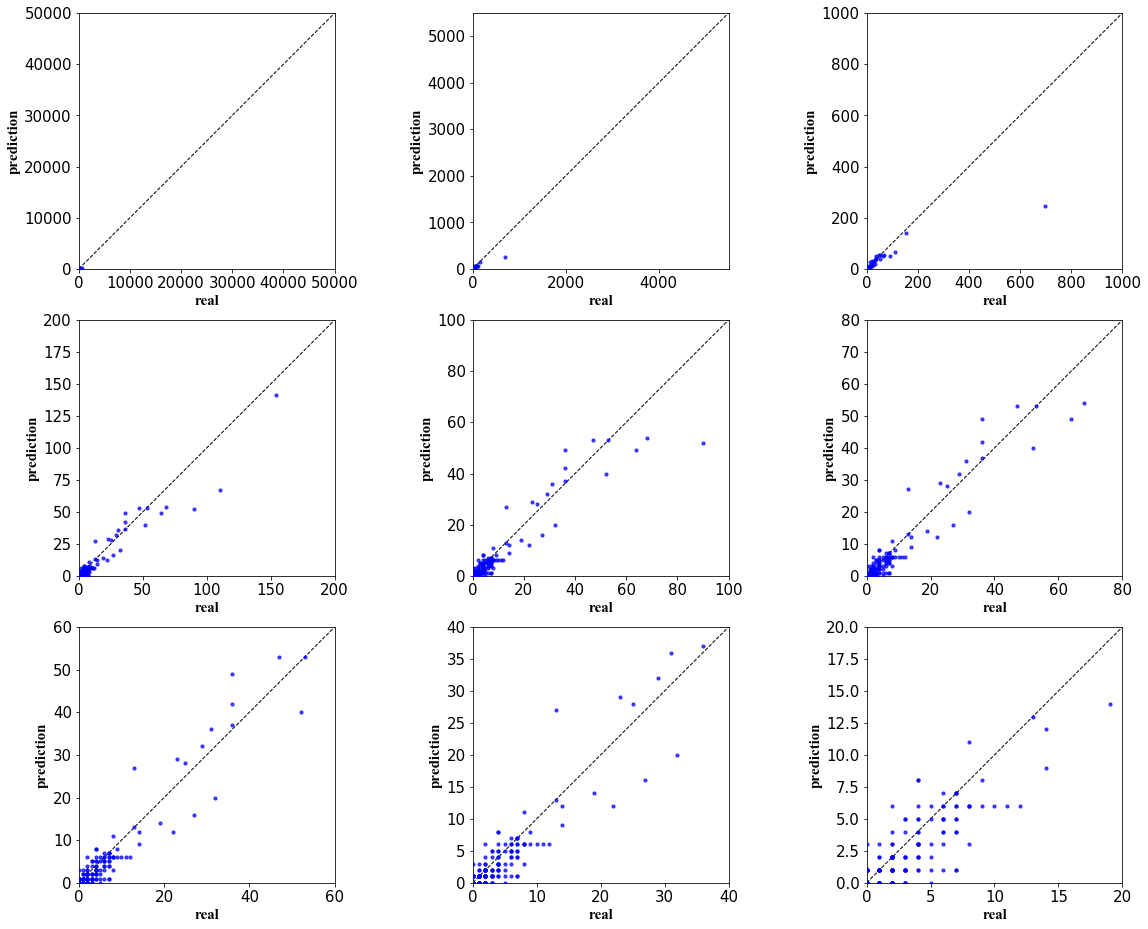

#########################################
test fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
ÈÑÇÂ∑ûÂ∏Ç   real: 20   pre:47.0
Â≠ùÊÑüÂ∏Ç   real: 100   pre:141.0
‰ªôÊ°ÉÂ∏Ç   real: 12   pre:41.0
ÊΩúÊ±üÂ∏Ç   real: 5   pre:30.0
ÈïøÊ≤ôÂ∏Ç   real: 22   pre:43.0
ÂπøÂ∑ûÂ∏Ç   real: 39   pre:67.0
R-squared 0.8483406855953723
R 0.9210541165400502
mae 3.1818181818181817
rmse 7.188719353988805


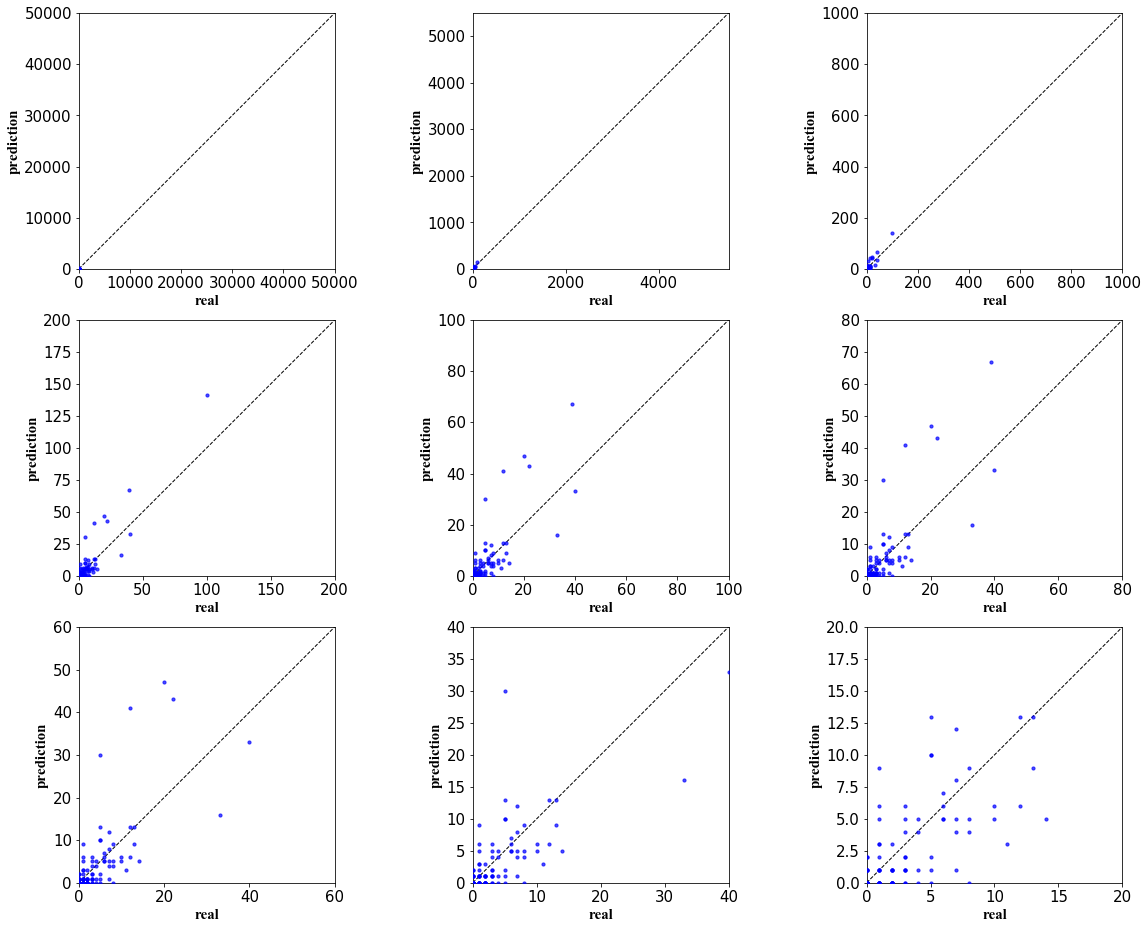

train fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
ËçÜÈó®Â∏Ç   real: 90   pre:54.0
Â≠ùÊÑüÂ∏Ç   real: 100   pre:55.0
Âí∏ÂÆÅÂ∏Ç   real: 64   pre:39.0
R-squared 0.9220475305201666
R 0.9602330605223748
mae 1.8630705394190872
rmse 4.742760370671278


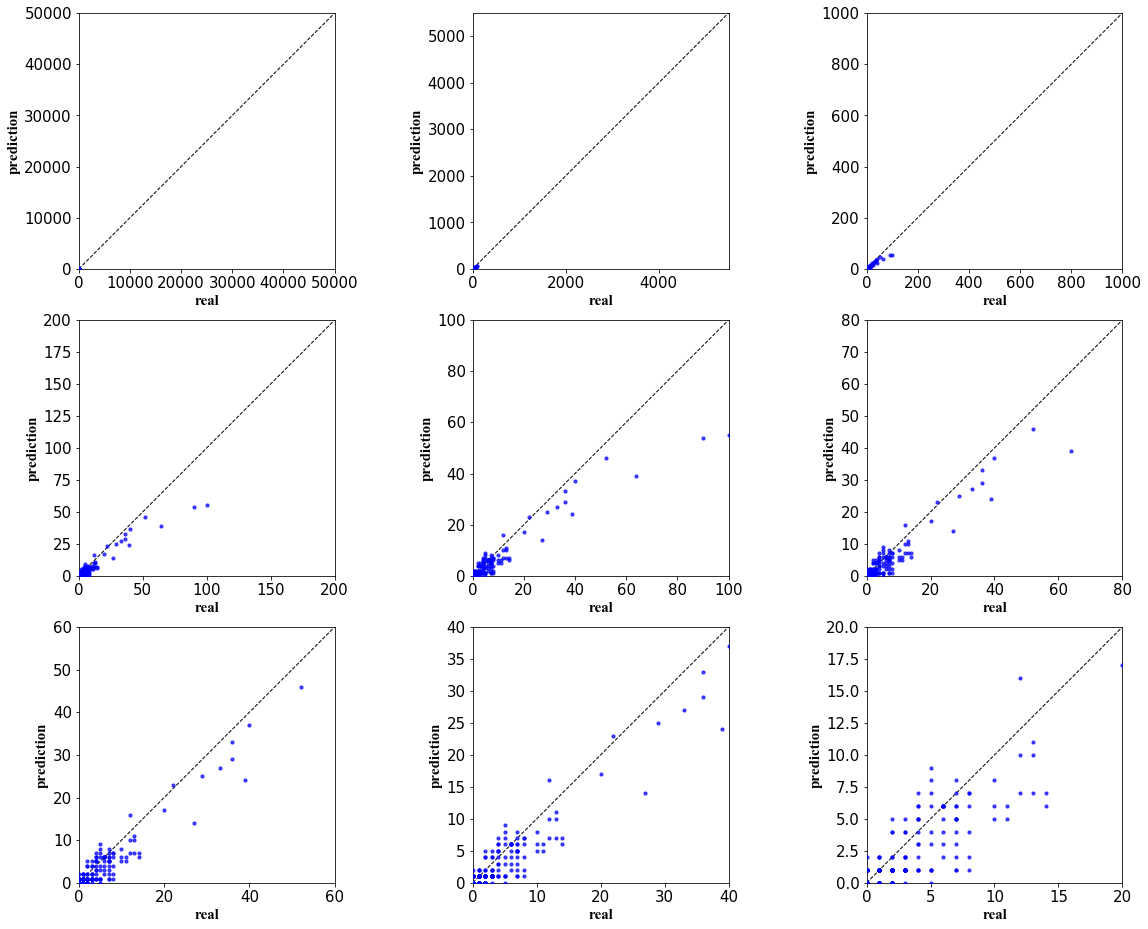

#########################################
test fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
Âåó‰∫¨Â∏Ç   real: 68   pre:25.0
‰∏äÊµ∑Â∏Ç   real: 53   pre:24.0
Ê∏©Â∑ûÂ∏Ç   real: 32   pre:7.0
Ê≠¶Ê±âÂ∏Ç   real: 698   pre:46.0
ÈªÑÂÜàÂ∏Ç   real: 154   pre:46.0
ÈáçÂ∫ÜÂ∏Ç   real: 110   pre:23.0
R-squared 0.3926088626388108
R 0.6265850801278393
mae 9.55
rmse 61.156356987642745


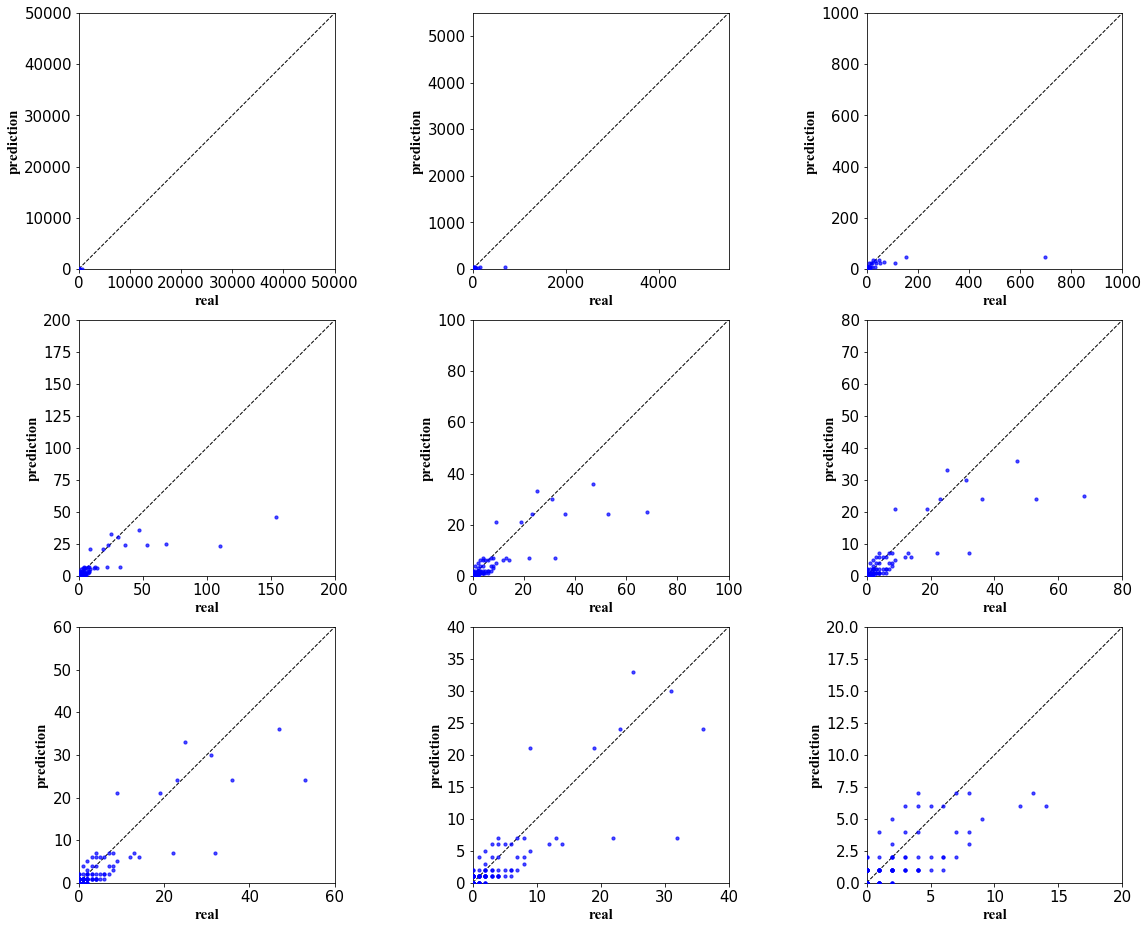

train fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
Ê≠¶Ê±âÂ∏Ç   real: 698   pre:166.0
Â≠ùÊÑüÂ∏Ç   real: 100   pre:75.0
ÈªÑÂÜàÂ∏Ç   real: 154   pre:75.0
ÈáçÂ∫ÜÂ∏Ç   real: 110   pre:53.0
R-squared 0.7747289167841744
R 0.8801868646964544
mae 4.352697095435684
rmse 34.99193742345946


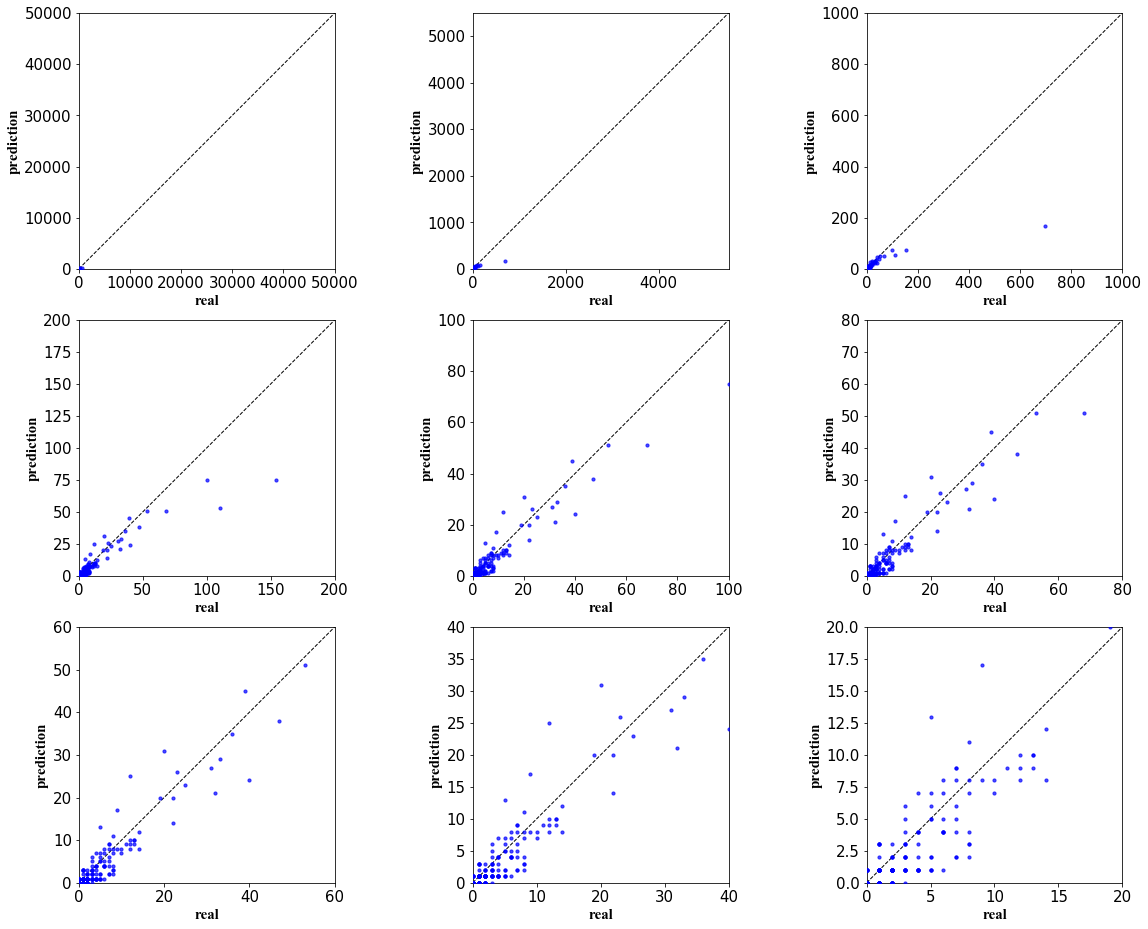

#########################################
test fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫20
ËçÜÈó®Â∏Ç   real: 90   pre:26.0
Âí∏ÂÆÅÂ∏Ç   real: 64   pre:25.0
ÈöèÂ∑ûÂ∏Ç   real: 52   pre:19.0
R-squared 0.6670954902915373
R 0.8167591384805788
mae 3.0166666666666666
rmse 8.10246875958186


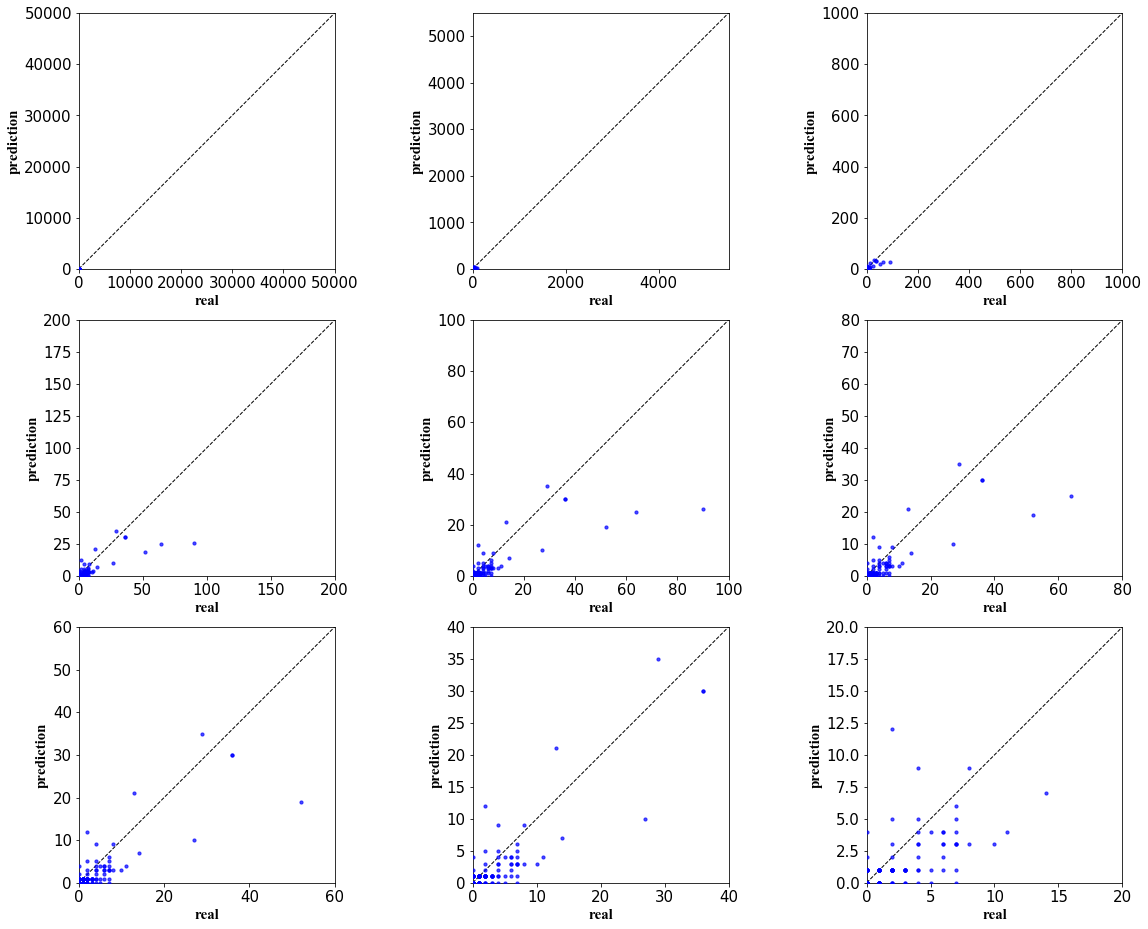

************* cv evaluation ***************
R-squared 0.2023580074399067
R 0.44984220282217485
mae 5.243767313019391
rmse 35.81048145051183


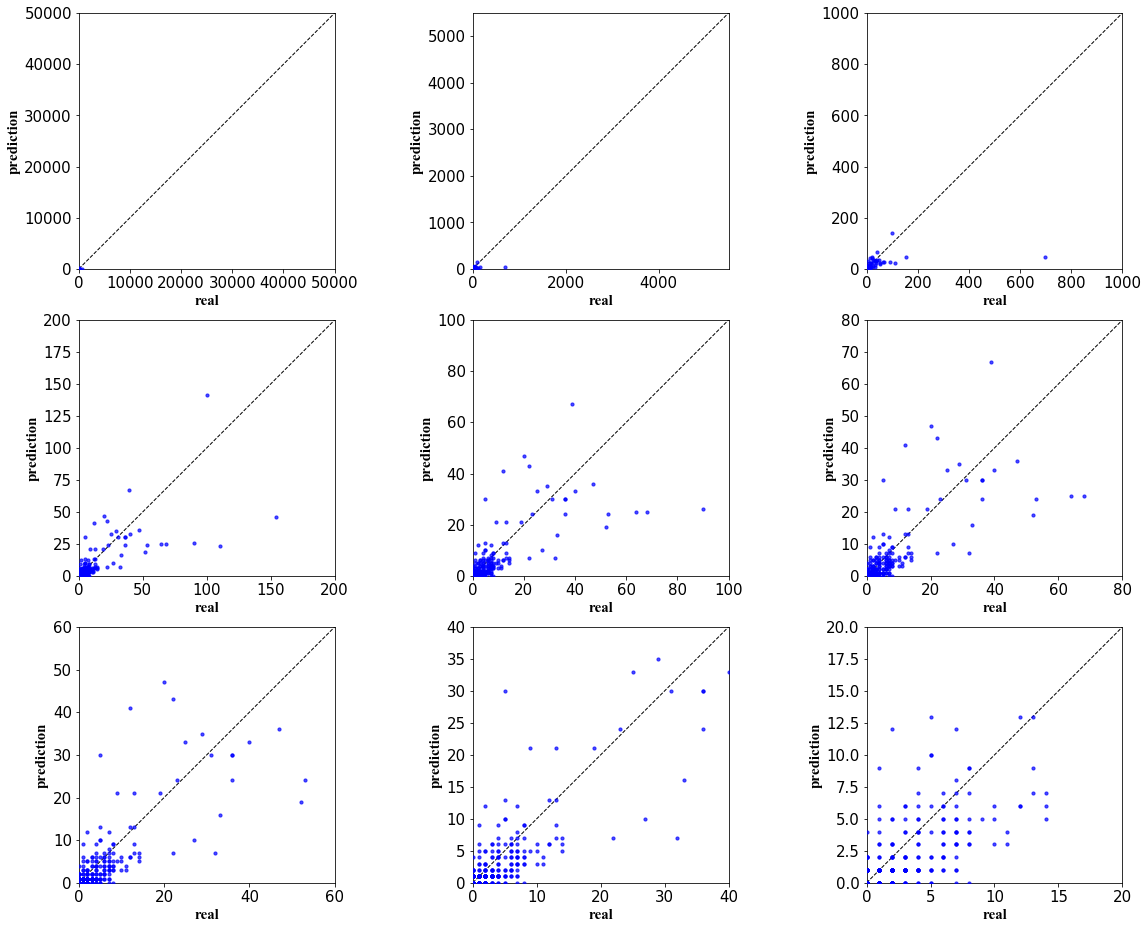

%%%%%% feature importances %%%%%%


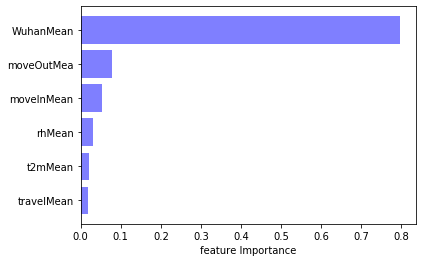

In [130]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")  
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id Áñ´ÊÉÖÁÅæÂå∫idÔºåÊöÇÂÆöÊ≠¶Ê±â
epidemicIds = [420100]

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 20)

In [131]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [132]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
167  420100      Ê≠¶Ê±âÂ∏Ç        698     46.0  82.161216  277.927893    3.691429   
176  421100      ÈªÑÂÜàÂ∏Ç        154     46.0  82.857096  277.756878    2.274531   
251  500000      ÈáçÂ∫ÜÂ∏Ç        110     23.0  81.690700  279.615017    6.699337   
173  420800      ËçÜÈó®Â∏Ç         90     26.0  79.101923  277.325860    0.786025   
0    110000      Âåó‰∫¨Â∏Ç         68     25.0  46.952353  267.598395    8.432141   
177  421200      Âí∏ÂÆÅÂ∏Ç         64     25.0  86.336734  278.122550    0.928249   
178  421300      ÈöèÂ∑ûÂ∏Ç         52     19.0  79.398717  276.382933    0.649905   
72   310000      ‰∏äÊµ∑Â∏Ç         53     24.0  80.613952  280.957940    6.154784   
88   330300      Ê∏©Â∑ûÂ∏Ç         32      7.0  81.075343  283.464677    1.632216   

     moveOutMea  travelMean   WuhanMean   diff  
167    6.322494    4.120335  100.000000  652.0  
176    1.006516    4.852458   12.606538  108.0  
251    5.046055    5.064838    1.210385   87.0  
173    0.501414    5.055546    3.047308   64.0  
0     13.719755    5.149477    1.179615   43.0  
177    0.532652    5.350531    5.103462   39.0  
178    0.343983    4.675454    2.953077   33.0  
72    12.054880    5.327500    0.891154   29.0  
88     3.456391    4.197485    0.201538   25.0

In [133]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
174  420900      Â≠ùÊÑüÂ∏Ç        100    141.0  80.659195  277.136510    1.596307   
180  429004      ‰ªôÊ°ÉÂ∏Ç         12     41.0  81.704573  277.975140    0.526281   
198  440100      ÂπøÂ∑ûÂ∏Ç         39     67.0  71.248583  290.618403    7.572659   
172  420700      ÈÑÇÂ∑ûÂ∏Ç         20     47.0  83.553880  278.572922    0.605509   
181  429005      ÊΩúÊ±üÂ∏Ç          5     30.0  79.753080  277.999688    0.332992   
184  430100      ÈïøÊ≤ôÂ∏Ç         22     43.0  85.910260  279.149545    4.208644   

     moveOutMea  travelMean  WuhanMean  diff  
174    0.961099    4.722062  13.395769 -41.0  
180    0.306374    4.384712   2.761154 -29.0  
198   14.140525    3.804012   0.671154 -28.0  
172    0.549913    4.082238   4.457692 -27.0  
181    0.221503    4.443785   1.108462 -25.0  
184    6.180231    4.447612   1.194231 -21.0

In [ ]:
# ÁÆ°ÊéßÂâçÈ¢ÑÊµãËøáÈ´òÂíåËøá‰ΩéÁöÑÊÉÖÂÜµ‰∏éÂÖ®Êó∂Èó¥ÊÆµÂü∫Êú¨Á±ª‰ºº

train fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
‰∏äÊµ∑Â∏Ç   real: 463   pre:321.0
Êù≠Â∑ûÂ∏Ç   real: 154   pre:94.0
Ê∏©Â∑ûÂ∏Ç   real: 472   pre:86.0
Âè∞Â∑ûÂ∏Ç   real: 124   pre:28.0
ËöåÂü†Â∏Ç   real: 157   pre:10.0
‰∫≥Â∑ûÂ∏Ç   real: 102   pre:25.0
ÂçóÊòåÂ∏Ç   real: 222   pre:151.0
Êñ∞‰ΩôÂ∏Ç   real: 127   pre:7.0
ÂÆúÊò•Â∏Ç   real: 100   pre:32.0
‰∏äÈ•∂Â∏Ç   real: 117   pre:59.0
‰ø°Èò≥Â∏Ç   real: 251   pre:177.0
È©ªÈ©¨Â∫óÂ∏Ç   real: 130   pre:74.0
Ê≠¶Ê±âÂ∏Ç   real: 49308   pre:10375.0
ÂçÅÂ†∞Â∏Ç   real: 632   pre:891.0
ÂÆúÊòåÂ∏Ç   real: 900   pre:1010.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1374   pre:1003.0
Â≠ùÊÑüÂ∏Ç   real: 3418   pre:2044.0
ËçÜÂ∑ûÂ∏Ç   real: 1533   pre:921.0
ÈöèÂ∑ûÂ∏Ç   real: 1255   pre:1078.0
ÊΩúÊ±üÂ∏Ç   real: 193   pre:274.0
Â§©Èó®Â∏Ç   real: 483   pre:738.0
Â®ÑÂ∫ïÂ∏Ç   real: 69   pre:14.0
Áè†Êµ∑Â∏Ç   real: 91   pre:28.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 76   pre:21.0
R-squared 0.9405471440770609
R 0.9698180984478795
mae 189.55
rmse 2515.5002236135856


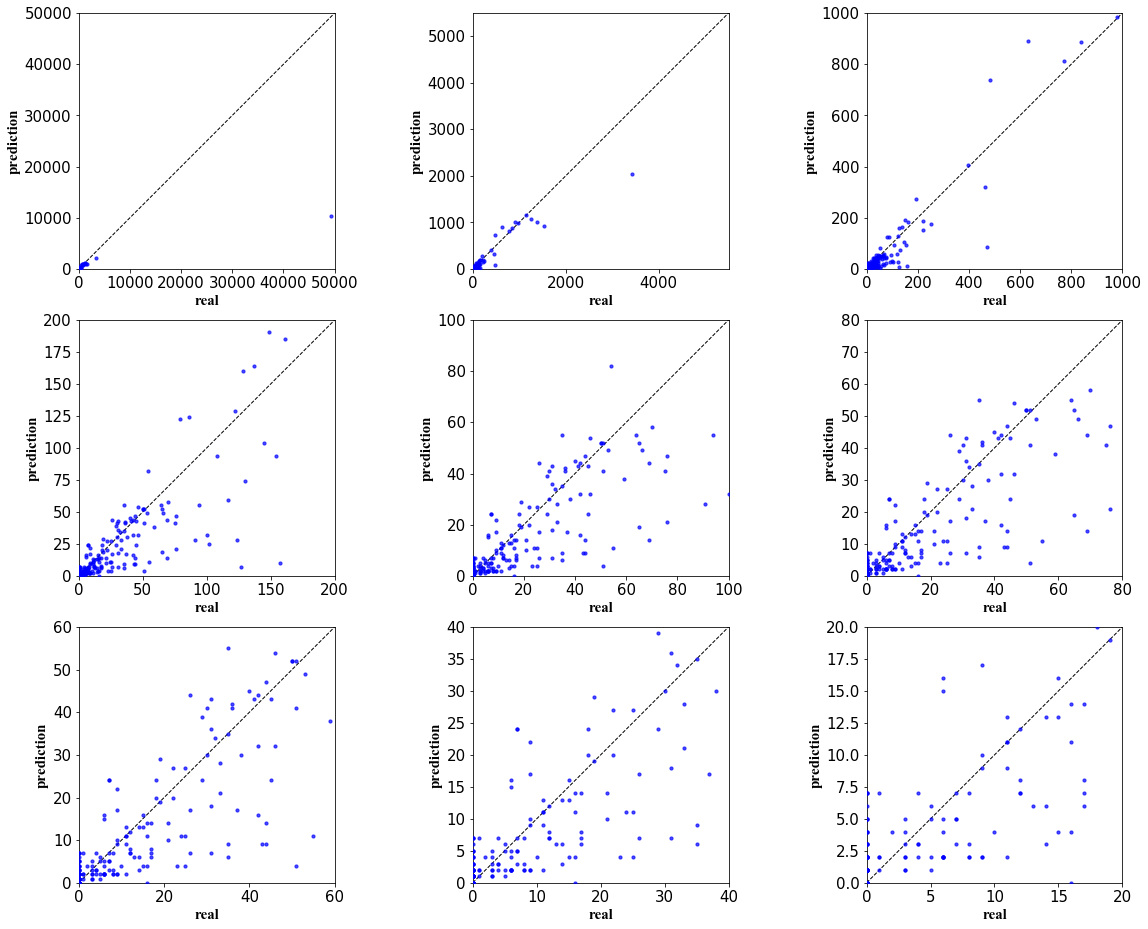

#########################################
test fold 1
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 512   pre:89.0
Â§©Ê¥•Â∏Ç   real: 160   pre:66.0
ÂìàÂ∞îÊª®Â∏Ç   real: 190   pre:31.0
ÂÆÅÊ≥¢Â∏Ç   real: 144   pre:52.0
‰πùÊ±üÂ∏Ç   real: 114   pre:191.0
ÊµéÂÆÅÂ∏Ç   real: 255   pre:41.0
ÈªÑÂÜàÂ∏Ç   real: 2753   pre:1391.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 227   pre:825.0
‰ªôÊ°ÉÂ∏Ç   real: 563   pre:969.0
Ê†™Ê¥≤Â∏Ç   real: 75   pre:210.0
‰∏úËéûÂ∏Ç   real: 98   pre:215.0
ÈáçÂ∫ÜÂ∏Ç   real: 469   pre:221.0
R-squared 0.7055931175269421
R 0.8399959032798565
mae 39.80165289256198
rmse 151.08122712661108


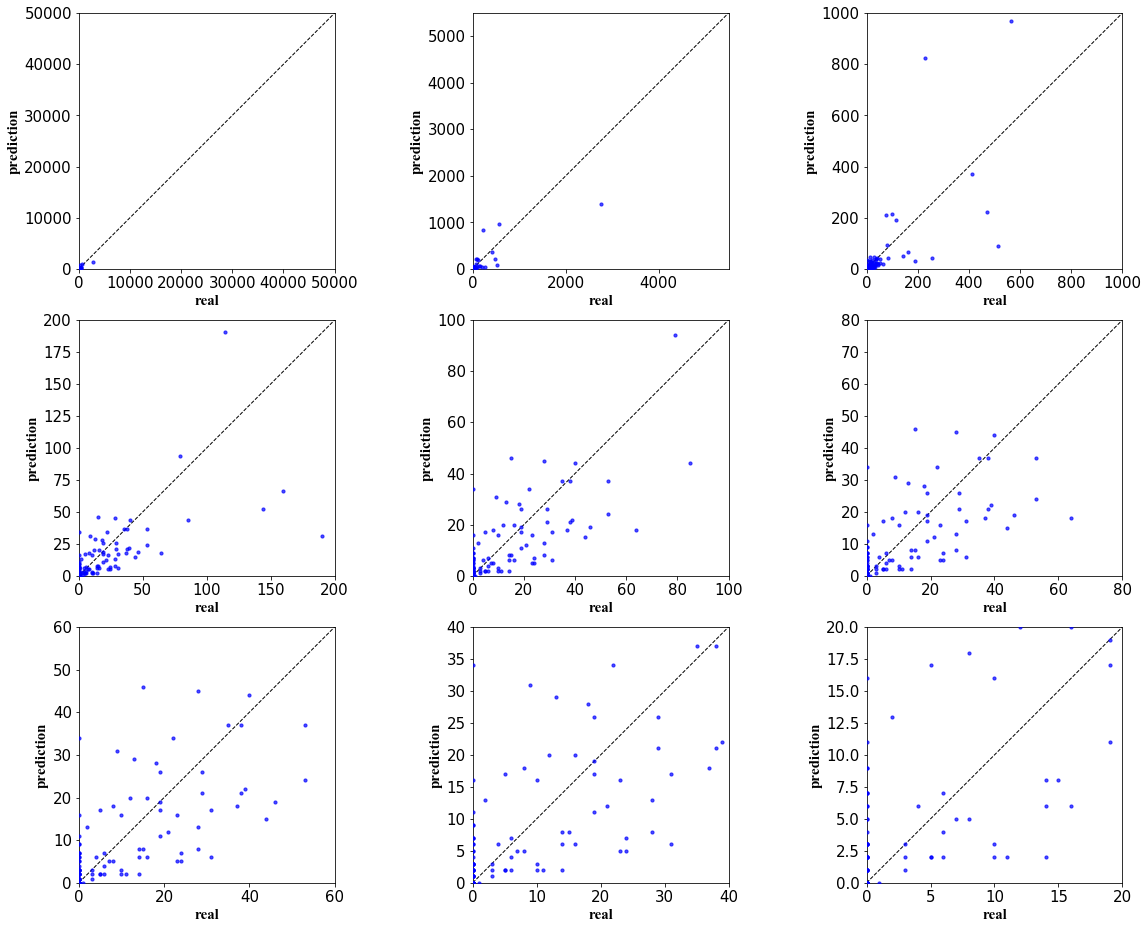

train fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 512   pre:180.0
Â§©Ê¥•Â∏Ç   real: 160   pre:90.0
ÂìàÂ∞îÊª®Â∏Ç   real: 190   pre:62.0
ÂÆÅÊ≥¢Â∏Ç   real: 144   pre:53.0
Êñ∞‰ΩôÂ∏Ç   real: 127   pre:6.0
ÂÆúÊò•Â∏Ç   real: 100   pre:37.0
ÊµéÂÆÅÂ∏Ç   real: 255   pre:41.0
ÈÉëÂ∑ûÂ∏Ç   real: 128   pre:219.0
È©ªÈ©¨Â∫óÂ∏Ç   real: 130   pre:59.0
ÂçÅÂ†∞Â∏Ç   real: 632   pre:715.0
ÂÆúÊòåÂ∏Ç   real: 900   pre:990.0
Ë•ÑÈò≥Â∏Ç   real: 1139   pre:711.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1374   pre:1070.0
ÈªÑÂÜàÂ∏Ç   real: 2753   pre:981.0
Âí∏ÂÆÅÂ∏Ç   real: 772   pre:947.0
ÈöèÂ∑ûÂ∏Ç   real: 1255   pre:992.0
‰ªôÊ°ÉÂ∏Ç   real: 563   pre:885.0
Ê†™Ê¥≤Â∏Ç   real: 75   pre:182.0
ÂπøÂ∑ûÂ∏Ç   real: 396   pre:341.0
ÈáçÂ∫ÜÂ∏Ç   real: 469   pre:244.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 76   pre:17.0
R-squared 0.7729634288372046
R 0.879183387489325
mae 27.448132780082986
rmse 128.03200779784282


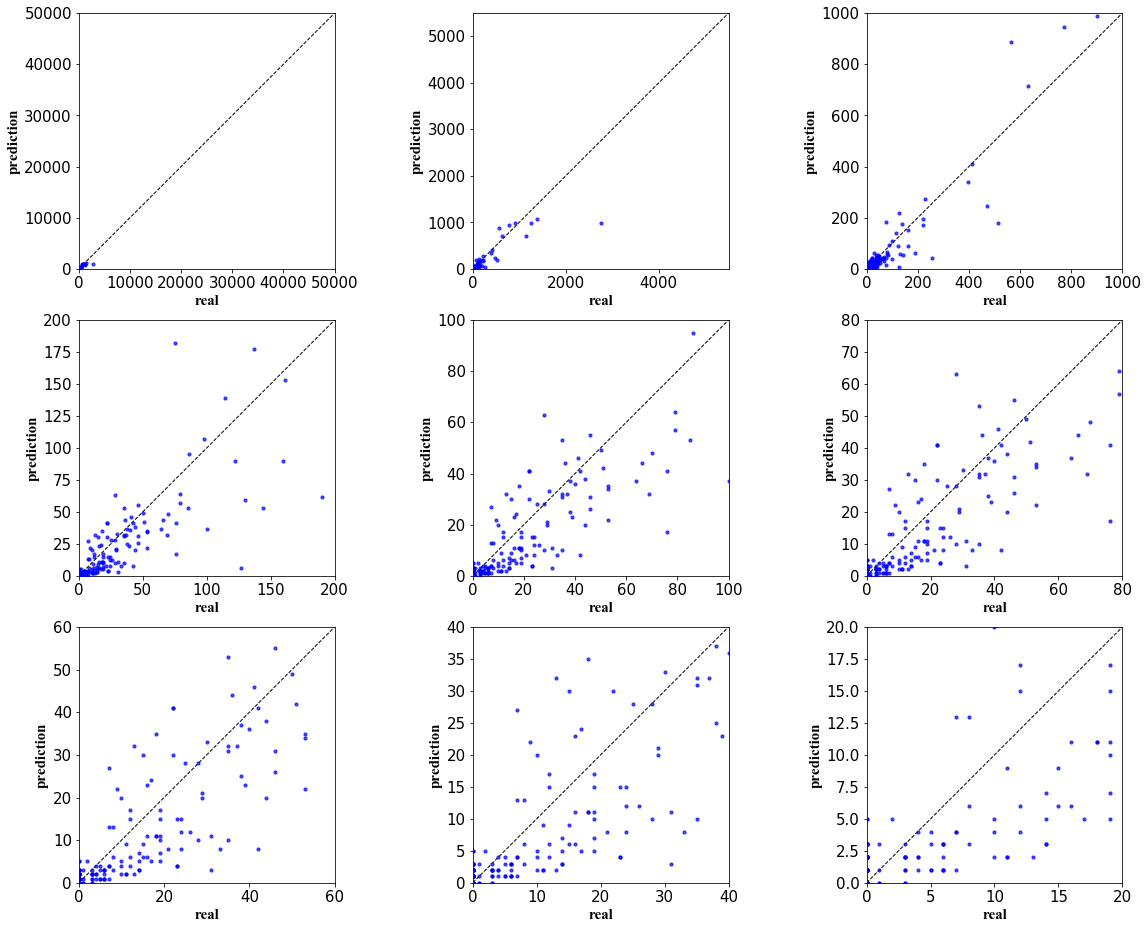

#########################################
test fold 2
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
ÂèåÈ∏≠Â±±Â∏Ç   real: 51   pre:0.0
‰∏äÊµ∑Â∏Ç   real: 463   pre:154.0
Êù≠Â∑ûÂ∏Ç   real: 154   pre:64.0
Ê∏©Â∑ûÂ∏Ç   real: 472   pre:30.0
Âè∞Â∑ûÂ∏Ç   real: 124   pre:11.0
ËöåÂü†Â∏Ç   real: 157   pre:5.0
ÈòúÈò≥Â∏Ç   real: 145   pre:64.0
‰∫≥Â∑ûÂ∏Ç   real: 102   pre:9.0
ËéÜÁî∞Â∏Ç   real: 55   pre:3.0
ÊäöÂ∑ûÂ∏Ç   real: 65   pre:10.0
‰∏äÈ•∂Â∏Ç   real: 117   pre:31.0
‰ø°Èò≥Â∏Ç   real: 251   pre:153.0
Ê≠¶Ê±âÂ∏Ç   real: 49308   pre:597.0
ÈªÑÁü≥Â∏Ç   real: 979   pre:898.0
Â≠ùÊÑüÂ∏Ç   real: 3418   pre:880.0
ËçÜÂ∑ûÂ∏Ç   real: 1533   pre:803.0
ÊΩúÊ±üÂ∏Ç   real: 193   pre:728.0
Â§©Èó®Â∏Ç   real: 483   pre:905.0
ÈÇµÈò≥Â∏Ç   real: 94   pre:18.0
Â®ÑÂ∫ïÂ∏Ç   real: 69   pre:16.0
Áè†Êµ∑Â∏Ç   real: 91   pre:11.0
R-squared 0.10048101645577613
R 0.3169874074088372
mae 465.325
rmse 4454.042960240356


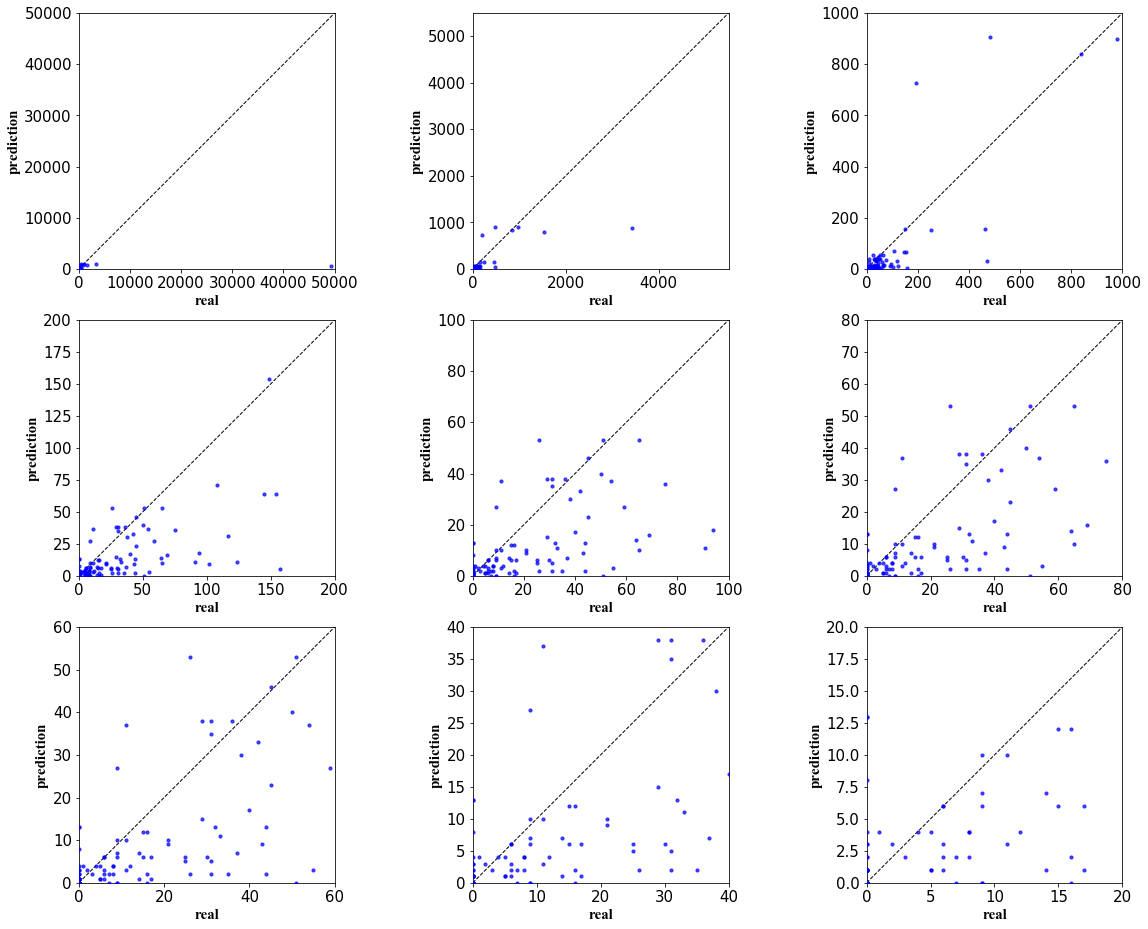

train fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âåó‰∫¨Â∏Ç   real: 512   pre:234.0
ÂìàÂ∞îÊª®Â∏Ç   real: 190   pre:76.0
‰∏äÊµ∑Â∏Ç   real: 463   pre:225.0
Êù≠Â∑ûÂ∏Ç   real: 154   pre:82.0
ÂÆÅÊ≥¢Â∏Ç   real: 144   pre:67.0
Ê∏©Â∑ûÂ∏Ç   real: 472   pre:75.0
Âè∞Â∑ûÂ∏Ç   real: 124   pre:60.0
ËöåÂü†Â∏Ç   real: 157   pre:46.0
ÈòúÈò≥Â∏Ç   real: 145   pre:60.0
‰∫≥Â∑ûÂ∏Ç   real: 102   pre:21.0
‰πùÊ±üÂ∏Ç   real: 114   pre:176.0
‰∏äÈ•∂Â∏Ç   real: 117   pre:38.0
ÊµéÂÆÅÂ∏Ç   real: 255   pre:42.0
Ê≠¶Ê±âÂ∏Ç   real: 49308   pre:20635.0
ÈªÑÁü≥Â∏Ç   real: 979   pre:725.0
ËçÜÈó®Â∏Ç   real: 838   pre:603.0
Â≠ùÊÑüÂ∏Ç   real: 3418   pre:2021.0
ËçÜÂ∑ûÂ∏Ç   real: 1533   pre:897.0
ÈªÑÂÜàÂ∏Ç   real: 2753   pre:2021.0
ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û   real: 227   pre:638.0
ÊΩúÊ±üÂ∏Ç   real: 193   pre:256.0
ÈÇµÈò≥Â∏Ç   real: 94   pre:13.0
Â≤≥Èò≥Â∏Ç   real: 149   pre:277.0
Â®ÑÂ∫ïÂ∏Ç   real: 69   pre:14.0
Áè†Êµ∑Â∏Ç   real: 91   pre:20.0
‰∏úËéûÂ∏Ç   real: 98   pre:149.0
ÈáçÂ∫ÜÂ∏Ç   real: 469   pre

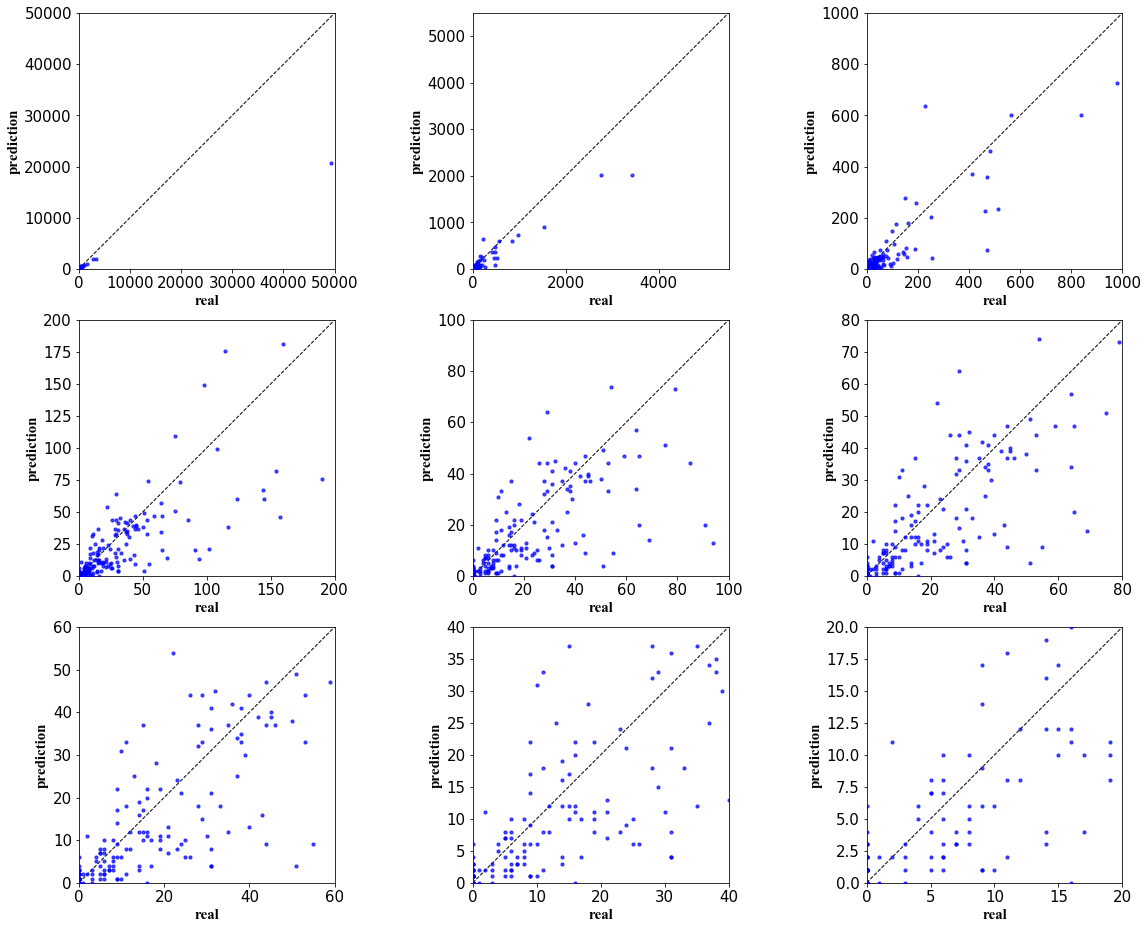

#########################################
test fold 3
È¢ÑÊµãËØØÂ∑ÆËæÉÂ§ßÂüéÂ∏ÇÔºåÁªùÂØπÂÄºËØØÂ∑ÆÈòàÂÄºËÆæÁΩÆ‰∏∫50
Âçó‰∫¨Â∏Ç   real: 86   pre:162.0
ÂçóÊòåÂ∏Ç   real: 222   pre:137.0
Êñ∞‰ΩôÂ∏Ç   real: 127   pre:2.0
ÂÆúÊò•Â∏Ç   real: 100   pre:38.0
ÈÉëÂ∑ûÂ∏Ç   real: 128   pre:367.0
ÂçóÈò≥Â∏Ç   real: 137   pre:285.0
È©ªÈ©¨Â∫óÂ∏Ç   real: 130   pre:49.0
ÂÆúÊòåÂ∏Ç   real: 900   pre:745.0
Ë•ÑÈò≥Â∏Ç   real: 1139   pre:745.0
ÈÑÇÂ∑ûÂ∏Ç   real: 1374   pre:725.0
ÈöèÂ∑ûÂ∏Ç   real: 1255   pre:462.0
ÈïøÊ≤ôÂ∏Ç   real: 220   pre:422.0
ÂπøÂ∑ûÂ∏Ç   real: 396   pre:162.0
ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û   real: 76   pre:0.0
R-squared 0.8224163291742691
R 0.906871726968191
mae 36.85
rmse 110.96606087748933


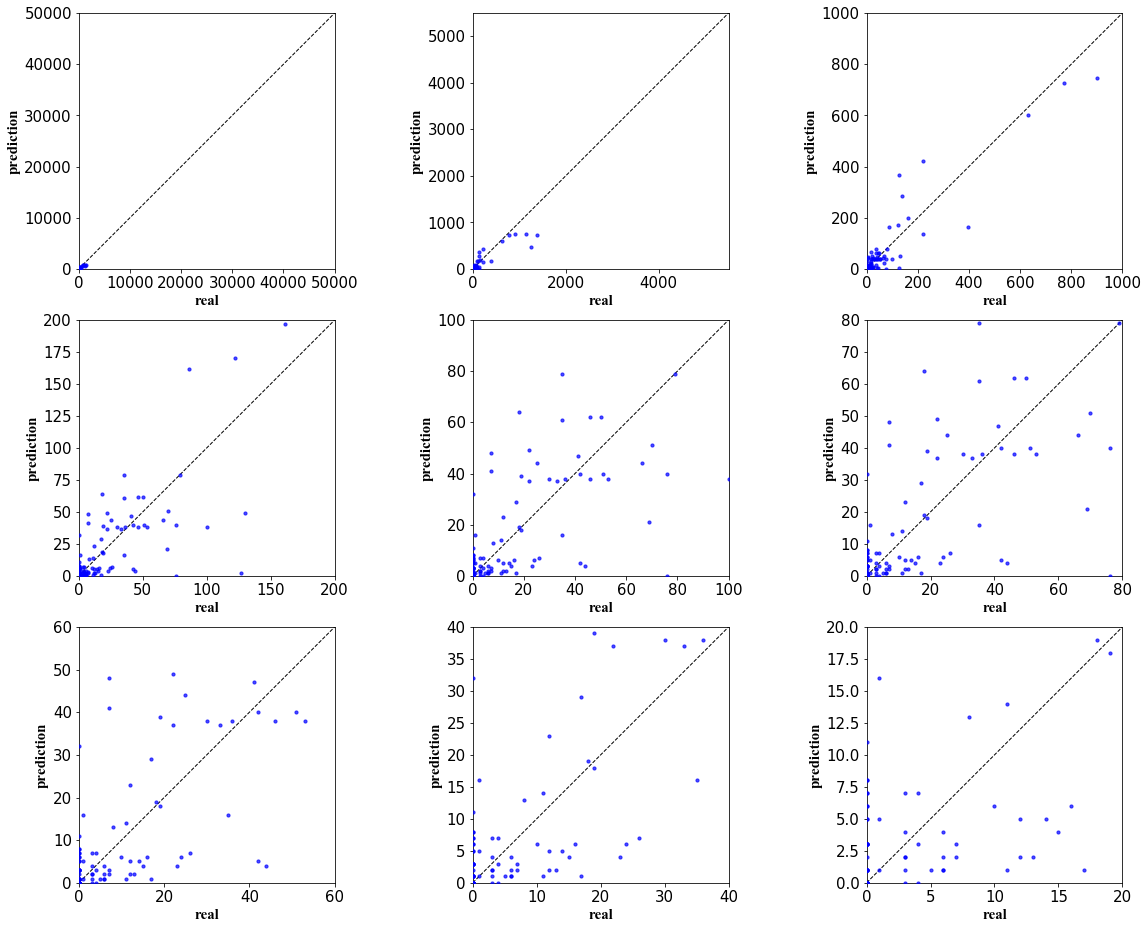

************* cv evaluation ***************
R-squared 0.06355433400643934
R 0.25209984927889056
mae 180.26869806094183
rmse 2570.264302457538


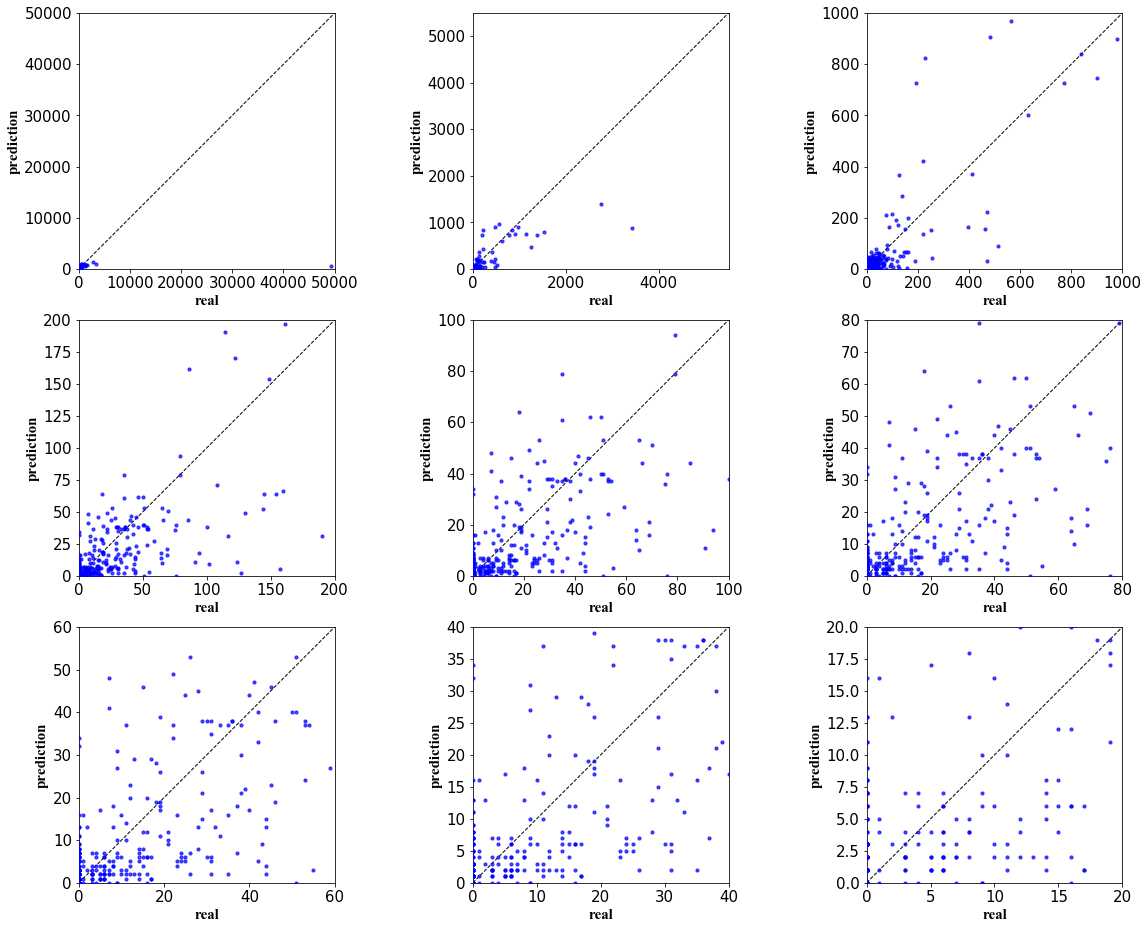

%%%%%% feature importances %%%%%%


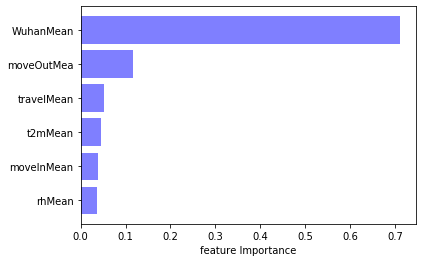

In [137]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# ÂÖ®Êó∂Èó¥ÊÆµÂª∫Ê®°
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold=50)

In [138]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [ ]:
# ÁÆ°ÊéßÂêéÈ¢ÑÊµãËøáÈ´òÂíåËøá‰ΩéÁöÑÊÉÖÂÜµ‰∏éÂÖ®Êó∂Èó¥ÊÆµÂü∫Êú¨Á±ª‰ºº

In [139]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

id location  confirmed  predict     rhMean     t2mMean  moveInMean  \
167  420100      Ê≠¶Ê±âÂ∏Ç      49308    597.0  67.548395  284.256138    0.542080   
174  420900      Â≠ùÊÑüÂ∏Ç       3418    880.0  67.495974  283.472206    0.175240   
176  421100      ÈªÑÂÜàÂ∏Ç       2753   1391.0  70.135725  283.436388    0.190124   
178  421300      ÈöèÂ∑ûÂ∏Ç       1255    462.0  67.635691  282.872199    0.073377   
175  421000      ËçÜÂ∑ûÂ∏Ç       1533    803.0  69.231072  284.337159    0.237780   
172  420700      ÈÑÇÂ∑ûÂ∏Ç       1374    725.0  68.977774  284.789154    0.080072   
88   330300      Ê∏©Â∑ûÂ∏Ç        472     30.0  77.923209  284.666702    0.941910   
0    110000      Âåó‰∫¨Â∏Ç        512     89.0  46.468169  274.994719    2.871917   
171  420600      Ë•ÑÈò≥Â∏Ç       1139    745.0  67.982955  282.419131    0.180650   
72   310000      ‰∏äÊµ∑Â∏Ç        463    154.0  70.698488  283.184662    3.597767   
251  500000      ÈáçÂ∫ÜÂ∏Ç        469    221.0  76.154281  283.584278    1.861806   
198  440100      ÂπøÂ∑ûÂ∏Ç        396    162.0  75.535987  291.145081    5.164597   
140  370800      ÊµéÂÆÅÂ∏Ç        255     41.0  56.263377  281.139767    0.655156   
59   230100     ÂìàÂ∞îÊª®Â∏Ç        190     31.0  52.731429  266.200924    0.707684   
170  420500      ÂÆúÊòåÂ∏Ç        900    745.0  74.232422  281.635819    0.186240   
99   340300      ËöåÂü†Â∏Ç        157      5.0  62.243918  282.380396    0.356936   
126  360500      Êñ∞‰ΩôÂ∏Ç        127      2.0  76.377866  285.450101    0.098953   
95   331000      Âè∞Â∑ûÂ∏Ç        124     11.0  74.510593  284.455340    0.685784   
163  411500      ‰ø°Èò≥Â∏Ç        251    153.0  65.156832  282.878631    0.330938   
1    120000      Â§©Ê¥•Â∏Ç        160     66.0  46.642699  277.967881    1.476379   
110  341600      ‰∫≥Â∑ûÂ∏Ç        102      9.0  60.748466  282.289942    0.485567   
87   330200      ÂÆÅÊ≥¢Â∏Ç        144     52.0  73.790800  283.983610    1.495799   
86   330100      Êù≠Â∑ûÂ∏Ç        154     64.0  74.497189  283.243679    2.749666   
132  361100      ‰∏äÈ•∂Â∏Ç        117     31.0  74.089452  285.501922    0.405214   
122  360100      ÂçóÊòåÂ∏Ç        222    137.0  73.035140  285.366712    0.798778   
107  341200      ÈòúÈò≥Â∏Ç        145     64.0  61.743429  282.633131    0.634403   
168  420200      ÈªÑÁü≥Â∏Ç        979    898.0  71.633199  284.422040    0.121287   
165  411700     È©ªÈ©¨Â∫óÂ∏Ç        130     49.0  62.218938  282.680697    0.455279   
201  440400      Áè†Êµ∑Â∏Ç         91     11.0  80.093177  292.072803    0.949299   
188  430500      ÈÇµÈò≥Â∏Ç         94     18.0  80.983450  284.155163    0.482991   
271  513300  ÁîòÂ≠úËóèÊóèËá™Ê≤ªÂ∑û         76      0.0  72.909072  263.841379    0.100721   
130  360900      ÂÆúÊò•Â∏Ç        100     38.0  75.889526  284.762245    0.388863   
131  361000      ÊäöÂ∑ûÂ∏Ç         65     10.0  78.343477  286.123932    0.249466   
196  431300      Â®ÑÂ∫ïÂ∏Ç         69     16.0  78.550672  283.944862    0.381381   
115  350300      ËéÜÁî∞Â∏Ç         55      3.0  78.624973  286.982403    0.261779   
63   230500     ÂèåÈ∏≠Â±±Â∏Ç         51      0.0  53.550778  266.646158    0.060108   

     moveOutMea  travelMean   WuhanMean     diff  
167    0.303700    0.764031  100.000000  48711.0  
174    0.276545    2.293580   16.315077   2538.0  
176    0.413585    2.800152   20.989077   1362.0  
178    0.132341    2.224703    1.853538    793.0  
175    0.419148    2.643878    6.812923    730.0  
172    0.096943    1.504028    5.203231    649.0  
88     0.587904    2.580782    0.042615    442.0  
0      1.396534    2.533645    0.182154    423.0  
171    0.282184    2.327737    3.511538    394.0  
72     1.888296    3.434394    0.299231    309.0  
251    2.256431    3.072905    0.315692    248.0  
198    3.251599    2.391931    0.291846    234.0  
140    0.872109    3.435500    0.010769    214.0  
59     0.582269    2.298325    0.042154    159.0  
170    0.215876    2.396275    5.157385    155.0  
99     0.523175    3.398728    0.004308

In [140]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

id    location  confirmed  predict     rhMean     t2mMean  \
179  422800  ÊÅ©ÊñΩÂúüÂÆ∂ÊóèËãóÊóèËá™Ê≤ªÂ∑û        227    825.0  78.710185  281.009652   
181  429005         ÊΩúÊ±üÂ∏Ç        193    728.0  68.510573  284.159537   
182  429006         Â§©Èó®Â∏Ç        483    905.0  67.397417  283.935709   
180  429004         ‰ªôÊ°ÉÂ∏Ç        563    969.0  68.048552  284.140160   
149  410100         ÈÉëÂ∑ûÂ∏Ç        128    367.0  54.497972  282.009780   
184  430100         ÈïøÊ≤ôÂ∏Ç        220    422.0  75.230205  284.888353   
161  411300         ÂçóÈò≥Â∏Ç        137    285.0  62.697251  281.920763   
185  430200         Ê†™Ê¥≤Â∏Ç         75    210.0  77.636058  285.841944   
214  441900         ‰∏úËéûÂ∏Ç         98    215.0  73.799657  292.110542   
125  360400         ‰πùÊ±üÂ∏Ç        114    191.0  75.150334  284.121798   
73   320100         Âçó‰∫¨Â∏Ç         86    162.0  66.526100  282.940633   

     moveInMean  moveOutMea  travelMean  WuhanMean   diff  
179    0.157376    0.257877    3.280932   5.884308 -598.0  
181    0.066477    0.086867    2.197575   1.019077 -535.0  
182    0.077401    0.139474    2.915722   2.029385 -422.0  
180    0.079986    0.113498    2.243594   3.041692 -406.0  
149    2.365988    1.453476    2.633251   0.407385 -239.0  
184    2.528474    1.823747    2.973386   0.542615 -202.0  
161    0.401780    0.791422    3.071334   0.349231 -148.0  
185    0.554582    0.612216    3.463406   0.298769 -135.0  
214    4.424677    2.442916    2.284398   0.179231 -117.0  
125    0.328033    0.535635    3.361745   0.301692  -77.0  
73     1.868585    1.199116    3.323195   0.185077  -76.0

In [141]:
# ÊÄªÁªì

# È¢ÑÊµãËøá‰ΩéÁöÑÊÉÖÂÜµ‚Äî‚ÄîÂÆûÈôÖÁ°ÆËØä‰∫∫Êï∞Âú®50~600ÔºåÈ¢ÑÊµã‰∫∫Êï∞‰∏•ÈáçÂÅè‰ΩéÔºåÂùáÂú®100‰ª•‰∏ãÔºåÁîöËá≥Êé•Ëøë‰∫é0ÔºåËøôÁ±ªÂüéÂ∏ÇÁöÑWuhanMeanÊûÅ‰ΩéÔºåÊé•Ëøë‰∫é0

# È¢ÑÊµãËøáÈ´òÁöÑÊÉÖÂÜµ‚Äî‚ÄîÂÆûÈôÖÁ°ÆËØä‰∫∫Êï∞Âú®200‰ª•‰∏ãÔºåÈ¢ÑÊµãÂüéÂ∏ÇÁ°ÆËØä‰∫∫Êï∞‰∏•ÈáçÂÅèÈ´òÔºåÂùáÂú®300‰ª•‰∏äÔºåÁîöËá≥Êé•Ëøë‰∫é1000ÔºåËøôÁ±ªÂüéÂ∏ÇÁöÑWuhanMeanËæÉÈ´ò

## ‰ª•‰∏ä‰∏§ÁßçÊÉÖÂÜµÊé®ÊµãÁôæÂ∫¶ËøÅÂæôÊåáÊï∞Êï∞ÊçÆÂ≠òÂú®ËØØÂ∑ÆÔºåÊØîÂ¶ÇÊ∏©Â∑ûÔºõ
## ÂæàÂ§öÂüéÂ∏Ç‰∏éÊ≠¶Ê±âÊ≤°ÊúâÁõ¥Êé•ËÅîÁ≥ªÔºåËøôÁ±ªÊÉÖÂÜµËÄÉËôëË°•ÂÖÖ‰∏éÁúÅ‰ºöÁöÑËøÅÂæôÔºåÊõ¥Â•ΩÁöÑË°®ËææÊñπÂºèÊàñËÆ∏ËøòÊòØÂõæÂç∑ÁßØ
## ÁõÆÂâçÁ≠õÈÄâÁöÑÁâπÂæÅÂπ∂‰∏çËÉΩÂÆåÂÖ®Ë°®ÂæÅÂüéÂ∏ÇÔºåÂ≠òÂú®‰∏Ä‰∫õÂüéÂ∏ÇÁâπÂæÅÂæàÊé•ËøëÔºå‰ΩÜÊòØlabelÂ∑ÆÂºÇËæÉÂ§ßÔºåËøôÁ±ªÊÉÖÂÜµÊ®°ÂûãÂè™ËÉΩÂÅöÊäò‰∏≠Â§ÑÁêÜÔºåÊó†Ê≥ïÂÅèÂêë‰ªª‰Ωï‰∏ÄÊñπ

### Âú®ËÆ°ÁÆócvÁöÑr2Êó∂ÔºåË¶Å‰∏çË¶ÅÊääÊ≠¶Ê±âÂéªÊéâÊù•ËÆ°ÁÆóÔºåÊàñËÄÖÂª∫Ê®°ÁöÑÊó∂ÂÄôÊääÂÆÉÊâîÊéâÔºüÔºüÔºüÈÇ£Ê†∑ÁªìÊûúÂÄíÊòØÂ•ΩÁúãÂæàÂ§öüòÅ